# Multi-Agent System
## Final Homework Assignment

In [ ]:
#imports 
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.interpolate import make_interp_spline, BSpline

## 1. Monte Carlo Tree Search (MCTS)
Construct a binary tree (each node has two child nodes) of depth d = 12 (or more – if you’re feeling lucky) and assign different values to each of the 2<sup>d</sup> leaf-nodes. Specifically, pick the leaf values to be real numbers randomly distributed between 0 and 100 (use the uniform continuous distribution U(0, 100), so don’t restrict yourself to integer values!).
<ul>
<li>
Implement the MCTS algorithm and apply it to the above tree to search for the optimal (i.e. highest) value.
</li>
<li>
Collect statistics on the performance and discuss the role of the hyperparameter c in the UCB-score.
</il>
</ul>
Assume that the number MCTS-iterations starting in a specific root node is limited (e.g. to 10
or 50). Make a similar assumption for the number of roll-outs starting in a particular (”snowcap”) leaf node (e.g. 1 or 5).

### Building the Environment
In the following cell are defined:
* The object Node $\rightarrow$ represents the tree nodes 
* The object MCTS $\rightarrow$ contains the logic of the MCTS algorithm
* Recursive creation of the binary tree
* checks


In [ ]:
class Node():
  """
  Class that defines the object "node" used by the MTCS algorithm
  """
  def __init__(self, parent=None, left=None, right=None, value=None):
    """
    Parameters
    ----------
      parent : Node
          if None, self is the root
      left && right : Node
          Children
      value : float value U(0,100)    
          if the node is a leaf
    """
    self.parent = parent
    self.left = left
    self.right = right
    self.value = value
    self._expanded = []     # list of node expanded (children) from this very node
    self._visits = 0        # number of visits 
    self._rewards = []      # list of all rewards obtained during th run
    # the two above are used in the algorithm variant
    self._n_rollout = 0     # keep count of the number of rollouts in this specific node
    self._is_new_root = False if parent else True  # it is setted True if the node became the root
                              
    
  def expansion(self):
    '''
    The node expands its self.
      it randomly explores child nodes
    '''
    if len(self._expanded) == 0:
      #child_node = np.random.choice([self.left, self.right])
      child_node = self.left
    else :
      #child_node = self.left if self._expanded[0] == self.right else self.right
      child_node = self.right
    self._expanded.append(child_node)
    return child_node
  
  def backup(self, reward):
    """
    After the rollout the algorithm update all the nodes from the snow-cap 
    to the root
    """
    self._visits+=1
    self._rewards.append(reward)
    if not self._is_new_root:
      if self.parent:
        self.parent.backup(reward)

  def set_as_new_root(self) :
    """
    Used in the variant algorithm
    Change the status of the node, in this way this node believes it is the root
    """
    if not self._is_new_root:
      self._is_new_root = True
    elif not self.is_leaf() : 
      raise()
  
  def is_leaf(self):
    """
    Return:
      True if the node is leaf, false otherwise
    """
    return self.left is None and self.right is None 
  
  def total_reward(self):
    """
    Return:
      List of all reward collected
    """
    return sum(self._rewards)

  def get_visits(self):
    """
    Return:
      Number of visits
    """
    return self._visits

  def rollout(self):
    """
    If this node is a leaf, this func returns its value, otherwise it continue
    recursively rollingout 
    """
    self._n_rollout += 1
    return self.value if self.is_leaf() else np.random.choice([self.left, self.right]).rollout()

  def best_child(self, c_param=1.4):
    """
    Return:
      the child with the highest value, according to the UCB-score
    """
    weights = [(child.total_reward()/child.get_visits()) + c_param*np.sqrt(2*np.log(self.get_visits())/child.get_visits()) for child in self._expanded]
    # print("wieghts: {}\nexpanded: {}\nargmax: {}\nresu: {}".format(weights, self._expanded, np.argmax(weights), self._expanded[np.argmax(weights)]))
    if len(weights) == 0 :
      #print("foglia joined the party ----------------")
      return self
    return self._expanded[np.argmax(weights)]

  def is_fully_expanded(self):
    if len(self._expanded) == 2:
      return True
    return False

  def to_string(self):
    """
    Return:
      the Node as a string
      Used to debug
    """
    return "parent: {}, children: {} - {}, visits: {}, rewards: {}, value: {},\
     as_root: {}".format(self.parent, self.left, self.right, self._visits, self._rewards, self.value, self._is_new_root)

  def get_best_reward(self):
    """
    Return :
      the best reward
    """
    return max(self._rewards)

  def get_n_rollout(self):
    """
    Return:
      number of rollouts from this specific node
    """
    return self._n_rollout
  
  def reset(self):
    self._expanded = []     # list of node expanded (children) from this very node
    self._visits = 0        # number of visits 
    self._rewards = []      # list of all rewards obtained during th run
    # the two above are used in the algorithm variant
    self._n_rollout = 0     # keep count of the number of rollouts in this specific node
    self._is_new_root = False if self.parent else True  # it is setted True if the node became the root


In [ ]:
class MCTS():
  """
  Actual implementation of the algorithms taken into account
  """
  def __init__(self, root, expansion_size, c_param=1.4):
    """
    Parameters
    ------------
    root : Node
        starting tree's node
    expansion_size : int
        dimension of the snow-cap
    c_param : float
        hyperparameter used by the UCB-score
    """
    self.root = root
    self.expansion_size = expansion_size
    self.c_param = c_param

  def best_action(self):
    """
    Returns
        the best_child found so far
    """
    for i in range(self.expansion_size):
      v = self._tree_policy()
      reward = v.rollout()
      v.backup(reward)
    # to select best child go for exploitation only
    return self.root.best_child()

  def best_action_variant(self, iterations=0, max_rollouts=0):
    """
    Used to implement the variant of the algorithm.
    If iterations and max_rollouts are 0 it behaves in the exact way
    
    Params
    -------------
    iterations : int
        Number of iterations from the root before changing it
    max_rollouts : int 
        Number of rollout from the same node brefore changing it
    """
    check = False
    v = self._tree_policy()
    for i in range(0, self.expansion_size):
      #print(i)
      if check:
        #print("not check")
        v = self._tree_policy()
      if iterations > 0 and i != 0 and i%iterations == 0 :
        #print("change root")
        self._change_root(v)
        v = self._tree_policy()
        #check = True
      elif v.get_n_rollout() >= max_rollouts:
        #print("change snow")
        v = self._tree_policy()
      reward = v.rollout()
      v.backup(reward)
    return self.root.best_child(self.c_param)
    

  def _tree_policy(self):
    """
    selects node to run rollout/playout for

    Returns:
      the best child or the next node found during the expansion phase
    """
    current_node = self.root
    #print("tree policy")
    while not current_node.is_leaf():
      if not current_node.is_fully_expanded():
        #print("expand")
        return current_node.expansion()
      else:
        #print("best")
        current_node = current_node.best_child(self.c_param)
    #print("fine tree")
    return current_node
  
  def _change_root(self, v):
    """
    Used in by the variant of the algorithm
    Change the root node
    """
    v.set_as_new_root()
    self.root = v

In [ ]:
def create_tree(node, depth, max_depth = 11):
  """
  Recursively create the binary tree

  The result will be a tree with (2^max_depth + 1) nodes
  """
  node_left = Node(parent=node)
  node_right = Node(parent=node)
  if depth < max_depth :
    create_tree(node_left,depth+1, max_depth)
    create_tree(node_right,depth+1, max_depth)
  else:
    node_left.value = np.random.uniform(0,100)
    node_right.value = np.random.uniform(0,100)
  node.left = node_left
  node.right = node_right

def reset_tree(node, depth, max_depth = 11):
  node.reset()
  if depth <= max_depth:
    reset_tree(node.left,depth+1,max_depth)
    reset_tree(node.right,depth+1,max_depth)

In [ ]:
"""
In this cell I check if the tree is correct
"""
root = Node()
depth = 10
create_tree(root, 1, depth)

for _ in range(100):
  current_node = root
  counter = 0
  reset_tree(root,1,depth)
  while not current_node.is_leaf():
    counter += 1
    current_node = np.random.choice([current_node.right, current_node.left])
  if counter != depth :
    raise("Unconsistences uccourred")

print(current_node.to_string())

parent: <__main__.Node object at 0x7f166adedeb8>, children: None - None, visits: 0, rewards: [], value: 78.56792767406286,     as_root: False


### Execution and Results
Run and results of the algorithm

In [ ]:
''' fixed parameters '''
np.random.seed(10)

episodes = 100
intervals = 3
depth = 14
interval = episodes/intervals
same_par_eps = 100

params = []
for i in range(episodes):
  if i <= interval:
    params.append(np.random.uniform(0,3))
  elif interval < i <= 2*interval:
    params.append(np.random.uniform(3,6))
  else :
    params.append(np.random.uniform(6,10))

root = Node()
create_tree(root, 1, depth)

In [ ]:
res_dict = {}
tim_dict = {}

for param in params:
  for _ in range(same_par_eps):
    reset_tree(root, 1, depth)
    start = time.time()
    mcts = MCTS(root, 100, c_param=param)
    res = mcts.best_action()
    end = time.time()
    if param in res_dict : 
      res_dict[param].append(res.get_best_reward())
      tim_dict[param].append(end-start)
    else:
      res_dict.update({param : [res.get_best_reward()]})
      tim_dict.update({param : [end-start]})

l1, l2, l3 = [[],[]],[[],[]],[[],[]]
for c, param in enumerate(params) :
  list_val = np.mean(res_dict[param])
  list_time = np.mean(tim_dict[param])
  if c <= interval:
    l1[0].append(list_val)
    l1[1].append(list_time)
  elif interval < c <= 2*interval:
    l2[0].append(list_val)
    l2[1].append(list_time)
  else :
    l3[0].append(list_val)
    l3[1].append(list_time)

print('val')
print(np.mean(l1[0]))
print(np.mean(l2[0]))
print(np.mean(l3[0]))
print(np.std(l1[0]))
print(np.std(l2[0]))
print(np.std(l3[0]))
print("time")
print(np.mean(l1[1]))
print(np.mean(l2[1]))
print(np.mean(l3[1]))
print(np.std(l1[1]))
print(np.std(l2[1]))
print(np.std(l3[1]))

max_val = {k : np.max(v) for k,v in res_dict.items()}
max_time = {k : np.min(v) for k,v in tim_dict.items()}
print("best results")
max_value = np.max(list(max_val.values()))  # maximum value
max_keys = [k for k, v in max_val.items() if v == max_value] # getting all keys containing the `maximum`
print("The best results have been computed with:\nc_params {} with the result {}".format(max_keys, max_value))
print("----"*40)
max_value = np.min(list(max_time.values()))  # maximum value
max_keys = [k for k, v in max_time.items() if v == max_value] # getting all keys containing the `maximum`
print("The quickest results have been computed with:\nc_params {} in time {}".format(max_keys, max_value))

val
97.32873658488609
97.65025854241844
97.9806653153418
0.19229936299104372
0.23745795857467605
0.28054724211907905
time
0.021994664248298195
0.022142556580630215
0.021010641618208453
0.000456617900232371
0.003040988996817127
0.0006018576511890004
best results
The best results have been computed with:
c_params [1.8375782004881644, 0.8756282045118995, 3.596842619036437, 3.8878851206390364, 3.9765349134967463, 3.4950476931574457, 4.177587731839762, 4.152343346076599, 5.478368531528219, 4.792114944692653, 3.1178453016761623, 7.670036575357068, 8.053866509633153, 7.980194523529818, 7.273091221915805] with the result 99.99898060044072
----------------------------------------------------------------------------------------------------------------------------------------------------------------
The quickest results have been computed with:
c_params [7.2034852357628285] in time 0.016269445419311523


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


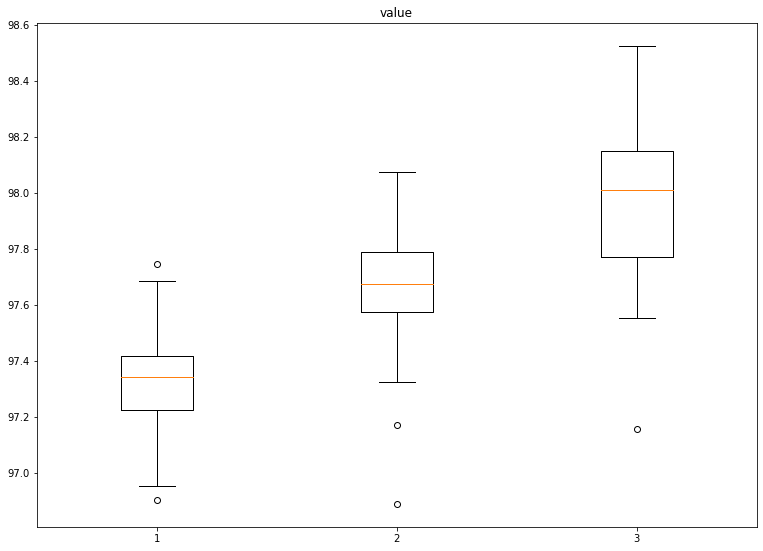

In [ ]:
data = [l1[0], l2[0], l3[0]] 
  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_title("value")
# Creating plot 
bp = ax.boxplot(data) 
  
# show plot 
plt.show() 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


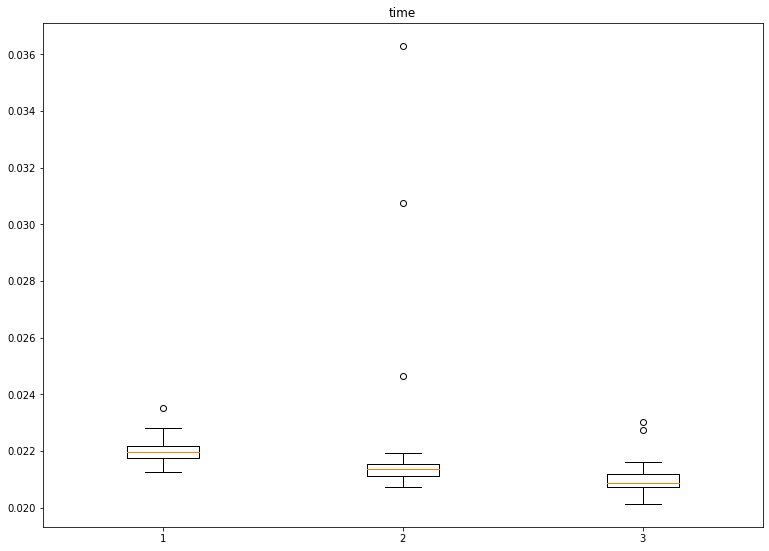

In [ ]:
data = [l1[1], l2[1], l3[1]] 
  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_title("time")
# Creating plot 
bp = ax.boxplot(data) 
  
# show plot 
plt.show() 

### Algorithm Variant

In [ ]:
res_dict = {}
tim_dict = {}

for param in params:
  for _ in range(same_par_eps):
    reset_tree(root, 1, depth)
    start = time.time()
    mcts = MCTS(root, 100, c_param=param)
    res = mcts.best_action_variant(iterations=10, max_rollouts=5)
    end = time.time()
    if param in res_dict : 
      res_dict[param].append(res.get_best_reward())
      tim_dict[param].append(end-start)
    else:
      res_dict.update({param : [res.get_best_reward()]})
      tim_dict.update({param : [end-start]})

l1, l2, l3 = [[],[]],[[],[]],[[],[]]
for c, param in enumerate(params) :
  list_val = np.mean(res_dict[param])
  list_time = np.mean(tim_dict[param])
  if c <= interval:
    l1[0].append(list_val)
    l1[1].append(list_time)
  elif interval < c <= 2*interval:
    l2[0].append(list_val)
    l2[1].append(list_time)
  else :
    l3[0].append(list_val)
    l3[1].append(list_time)

print('val')
print(np.mean(l1[0]))
print(np.mean(l2[0]))
print(np.mean(l3[0]))
print(np.std(l1[0]))
print(np.std(l2[0]))
print(np.std(l3[0]))
print("time")
print(np.mean(l1[1]))
print(np.mean(l2[1]))
print(np.mean(l3[1]))
print(np.std(l1[1]))
print(np.std(l2[1]))
print(np.std(l3[1]))

max_val = {k : np.max(v) for k,v in res_dict.items()}
max_time = {k : np.min(v) for k,v in tim_dict.items()}
print("best results")
max_value = np.max(list(max_val.values()))  # maximum value
max_keys = [k for k, v in max_val.items() if v == max_value] # getting all keys containing the `maximum`
print("The best results have been computed with:\nc_params {} with the result {}".format(max_keys, max_value))
print("----"*40)
max_value = np.min(list(max_time.values()))  # maximum value
max_keys = [k for k, v in max_time.items() if v == max_value] # getting all keys containing the `maximum`
print("The quickest results have been computed with:\nc_params {} in time {}".format(max_keys, max_value))

val
70.81238366046149
71.0044693060502
69.90327218059558
2.58558765503399
2.2426368816581883
2.7843329449518444
time
0.005548066041048835
0.005477215521263354
0.005409557096885911
0.0002592858082010353
0.0002938045558097213
0.00012846230705920944
best results
The best results have been computed with:
c_params [1.3254995232689883] with the result 99.9742777909958
----------------------------------------------------------------------------------------------------------------------------------------------------------------
The quickest results have been computed with:
c_params [2.246411647615836] in time 0.00471186637878418


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


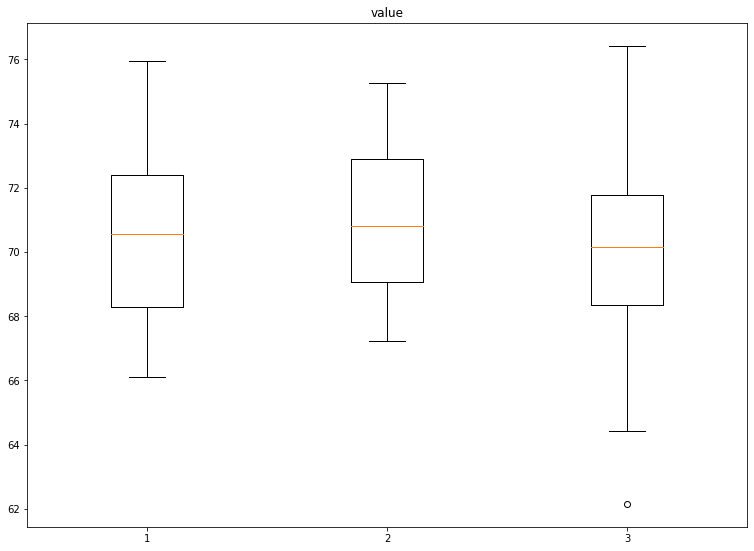

In [ ]:
data = [l1[0], l2[0], l3[0]] 
  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_title("value")
# Creating plot 
bp = ax.boxplot(data) 
  
# show plot 
plt.show() 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


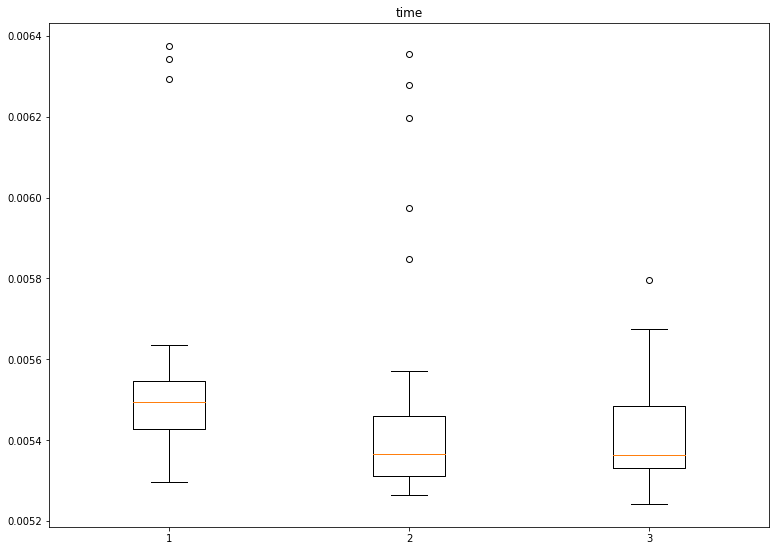

In [ ]:
data = [l1[1], l2[1], l3[1]] 
  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_title("time")
# Creating plot 
bp = ax.boxplot(data) 
  
# show plot 
plt.show() 

## 2. Reinforcement Learning: SARSA and Q-Learning for Gridworld
Consider the 9 × 9 gridworld example depicted in the figure below. The blue gridcells represent walls that cannot be traversed. The green cell represent a treasure and transition to this cell yields a reward of +50 where upon the episode is terminated (i.e. absorbing state). The red cell represents the snakepit: this state is also absorbing and entering it yields a negative reward of −50. All other cells represent regular states that are accessible to the agent. In each cell, the agent can take four actions: move north, east, south or west. These actions result in a deterministic transition to the corresponding neighbouring cell. An action that makes the agent bump into a wall or the grid-borders, leaves its state unchanged. All non-terminal transitions (including running into walls or grid borders) incur a negative reward (”cost”) of −1.

For the questions below, we assume that the agent is not aware of all the above information and needs to discover it by interacting with the environment (i.e. model-free setting). Perform, and comment on, the following experiments:


* Use Monte Carlo policy evaluation to compute the state value function <i>v<inf>π</inf>(s)</i> for the <b>equiprobable policy</b> π (i.e. all 4 actions have probability 1/4). Visualize the result (e.g.
by using some sort of heat map where the color of each cell corresponds to the state value).

* Use SARSA in combination with greedification to search for an optimal policy.

* Use Q-learning to search for an optimal policy. Compare to the solution obtained by SARSA

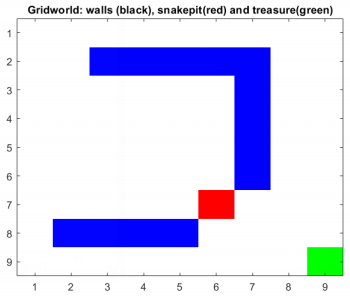

### Building the Environment
States, actions, rewards and states' are defined in the environment.

Each Cell defines a state.


In [ ]:
from enum import Enum

class Actions(Enum):
  """
  Actions that can be taken by the agent
  """
  NORTH = 1
  EAST = 2
  SOUTH = 3
  WEST = 4

In [ ]:
class Cell():
  """
  Class that defines the object "Cell" used to design the Gridworld
  """
  def __init__(self, coordinates=(0,0), is_type=None, reward=-1, colour="White"):
    """
    Parameters
    -----------
    coordinates : (int, int)
        position of the cell in the gridworld
    is_type can be: str --> None, Wall, Pit, Goal
        define the type of this specific cell
    reward : int
        define the reward of the cell
    colour : str
        colour of it representation
    """
    self.coordinates = coordinates
    self.is_type = is_type
    self.immediate_reward = reward
    self.colour = colour
    self._vvalue = 0
    self._qvalues = {} # {action : value}
    for action in Actions: 
      self._qvalues.update({action : 0})

  def set_qvalue(self, action, value):
    self._qvalues.update({action : value})

  def set_vvalue(self, value):
    self._vvalue = value

  def get_qvalue(self, action):
    return self._qvalues[action]
    
  def get_row(self):
    return self.coordinates[0]

  def get_col(self):
    return self.coordinates[1]
  
  def is_normal(self):
    return self.is_type == None

  def is_wall(self):
    return self.is_type == "Wall"

  def is_pit(self):
    return self.is_type == "Pit"

  def is_goal(self):
    return self.is_type == "Goal"
  
  def is_absorbing(self):
    return self.is_type == "Pit" or self.is_type == "Goal"
  
  def get_vvalue(self):
    return self._vvalue

  def get_qvalue(self):
    sum = 0
    for k, v in self._qvalues.items():
      sum += 1/4 * v
    return sum

In [ ]:
class World():
  """
  Class that collects cells and define the logic of the environment
  """
  def __init__(self, width=9, height=9):
    """
    Parameters
    -----------
    width && height : define matrix of cells
    e.g.-->[[(0,0),(0,1), ... (0,8)],
             ...                ...
            [(8,0),(8,1), ... (8,8)]]
    """
    self._width = width
    self._height = height
    self._cells = []

  def next_cell(self, action, actor_cell):
    """
    From the current cell, the agent moves to the next one according to the action
    """
    x = actor_cell.get_col()
    y = actor_cell.get_row()
    try:
      if action == Actions.NORTH :
        next = self.get_cell(x-1,y)
      elif action == Actions.EAST :
        next = self.get_cell(x,y+1)
      elif action == Actions.SOUTH :
        next = self.get_cell(x+1,y)
      elif action == Actions.WEST :
        next = self.get_cell(x,y-1)
    except :
      # if the agent goes out of border an exception is rised
      next = self.get_cell(x,y)
    if next.is_wall():
      next = self.get_cell(x,y)
    return next
  
  def create_map(self):
    """
    Generate a map according to the lines of the assignment
    """
    for row in range(0,self._height) :
      self._cells.append([])
      for col in range(0, self._width) :
        if (row == 1 and (2 <= col <= 6)) or ((2 <= row <= 5) and col == 6) or (row == 7 and (1 <= col <= 4)):
          cell = Cell(coordinates=(row,col), is_type="Wall", colour="Black")
        elif row == 6 and col == 5 :
          cell = Cell(coordinates=(row,col), is_type="Pit", reward=-50, colour="Red")
        elif row == 8 and col == 8 :
          cell = Cell(coordinates=(row,col), is_type="Goal", reward=50, colour="Green")
        else :
          cell = Cell(coordinates=(row,col), is_type=None, colour="White")
        self._cells[row].append(cell)

  def plot_map(self, is_vvalue=False):
    """
    Generate a heatmap plot using the cells inside the world
    Params
    -------------
    is_vvalue : Bool
        if false the heatmap is created using vvalues of the cells (MC policy evaluation)
        otherwise the map is created using the qvalues
    """
    rows = [e for e in range(0,len(self._cells))]
    cols = [e for e in range(0,len(self._cells[0]))]
    heat_map = []
    # CREATION OF THE HEATMAP -----------
    for c, row in enumerate(self._cells) :
      heat_map.append([])
      if is_vvalue :
        heat_map[c].extend([cell.get_vvalue() for cell in row])
      else:
        heat_map[c].extend([cell.get_qvalue() for cell in row])
    heat_map = np.array(heat_map)
    # START PLOTTING -------- 
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(heat_map)

    # We want to show all ticks...
    ax.set_xticks(np.arange(0, len(cols)))
    ax.set_yticks(np.arange(0, len(rows)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([str(e+1) for e in range(0, len(cols))])
    ax.set_yticklabels([str(e+1) for e in range(0, len(rows))])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(0, len(cols)):
        for j in range(0, len(rows)):
          if self.get_cell(i,j).is_wall():
            text = ax.text(i, j, "Wall",
                          ha="center", va="center", color=self._cells[j][i].colour)#
          elif self.get_cell(i,j).is_pit():
            text = ax.text(i, j, "Pit",
                          ha="center", va="center", color=self._cells[j][i].colour)#
          elif self.get_cell(i,j).is_goal():
            text = ax.text(i, j, "Goal",
                          ha="center", va="center", color=self._cells[j][i].colour)#
          else:
            text = ax.text(i, j, round(heat_map[j, i], 3),
                        ha="center", va="center", color=self._cells[j][i].colour) # colour="w"

    ax.set_title("Qvalues heatmap" if is_vvalue else "Vvalues heatmap")
    fig.tight_layout()
    plt.show()
  
  def get_cell(self, x, y):
    """
    Raise and exception if the agent goes out of the borders
    """
    if(x < 0 or y < 0):
      raise Exception("index out of bound")
    return self._cells[y][x]

  def get_all_cells(self):
    """
    Return matrix of cells
    """
    return self._cells
  
  def get_cells_as_list(self):
    """
    Return cells as a list instead of a metrix
    """
    res = []
    for row in self._cells :
      for cell in row :
        res.append(cell)
    return res

  def shape(self):
    """
    Return the shape of the world
    """
    return (self._height, self._width)
    

### Monte Carlo Evaluation
In the following cells the logic of Monte Carlo policy evaluation is defined inside the object MonteCarlo.
Then the execution is computed and the results displayed.

In [ ]:
class MonteCarlo():
  """
  This object contains the logic of the algorithm
  """
  def __init__(self, world, pi, gamma=0.99):
    """
    world : World

    pi : dict{action : probability of taking the action}
        policy tbe
    gamma : float 0<=x<=1
    """
    self.pi = pi
    self.world = world
    self.gamma = gamma
    self.N = [[0]*self.world.shape()[0]]*self.world.shape()[1]
    self.S = [[0]*self.world.shape()[0]]*self.world.shape()[1]
    self.vvalues = [[0]*self.world.shape()[0]]*self.world.shape()[1]
    self._cell_dict = {} # for each cell stores the list of states explored at each repetition
    for cell in self.world.get_cells_as_list():
      self._cell_dict.update({cell : []})

  def get_action(self):
    """
    Return one of the action defined by the policiy wrt its probability
    """
    return np.random.choice(list(self.pi.keys()), p=list(self.pi.values()))

  def generate_episode(self,start_x = 0, start_y = 0):
    """
    Starting from the cell in position (start_x,start_y) generates an episode 
    using pi
    """
    G, timestep, total_reward = 0, 0, []
    s = self.world.get_cell(start_x,start_y)
    states_in_episode = []
    # Loop until the goal or pit is reached
    while not s.is_absorbing():
      states_in_episode.append(s)
      a = self.get_action()
      next_s = self.world.next_cell(a, s)
      total_reward.append(self.gamma * next_s.immediate_reward)
      # G += (self.gamma ** timestep)* next_s.immediate_reward 
      s = next_s
      timestep += 1
    return states_in_episode, G, total_reward
  
  def simulation(self, repetitions=1000, x=0, y=0, first_visit_on=True):
    """
    Run a simulation --> generates several epiodes and stores the results
    Prams
    --------
    repetitions : int
        number of episods tbe
    x&&y : int
        coordinates of the starting cell
    """
    store = []
    for i in range(repetitions):
      # Generate an episode using pi
      sie, G, tr = self.generate_episode(x,y)
      firs_occ = []
      for c, state in enumerate(sie):
        if first_visit_on: # check if first-visit or every-visit
          if state not in firs_occ:
            # R <-- return following the first occurrence of s
            firs_occ.append(state)
            # Append R to Return(s)
            self._cell_dict[state].append(np.sum(tr[c:]))
        else :
          self._cell_dict[state].append(np.sum(tr[c:]))
    
  def update(self):
    for k,v in self._cell_dict.items():
      if len(v) > 0 :
        # V(s) <- average(Returns(s))
        k.set_vvalue(np.mean(v))

In [ ]:
'''
Fixed parameters
'''

policy = {
    Actions.NORTH : 0.25,
    Actions.EAST : 0.25,
    Actions.SOUTH : 0.25,
    Actions.WEST : 0.25
}

repetitions = [10,100,300]#,500]#, 1000]

#### First-visit Results

Heatmap with 10 repetitions


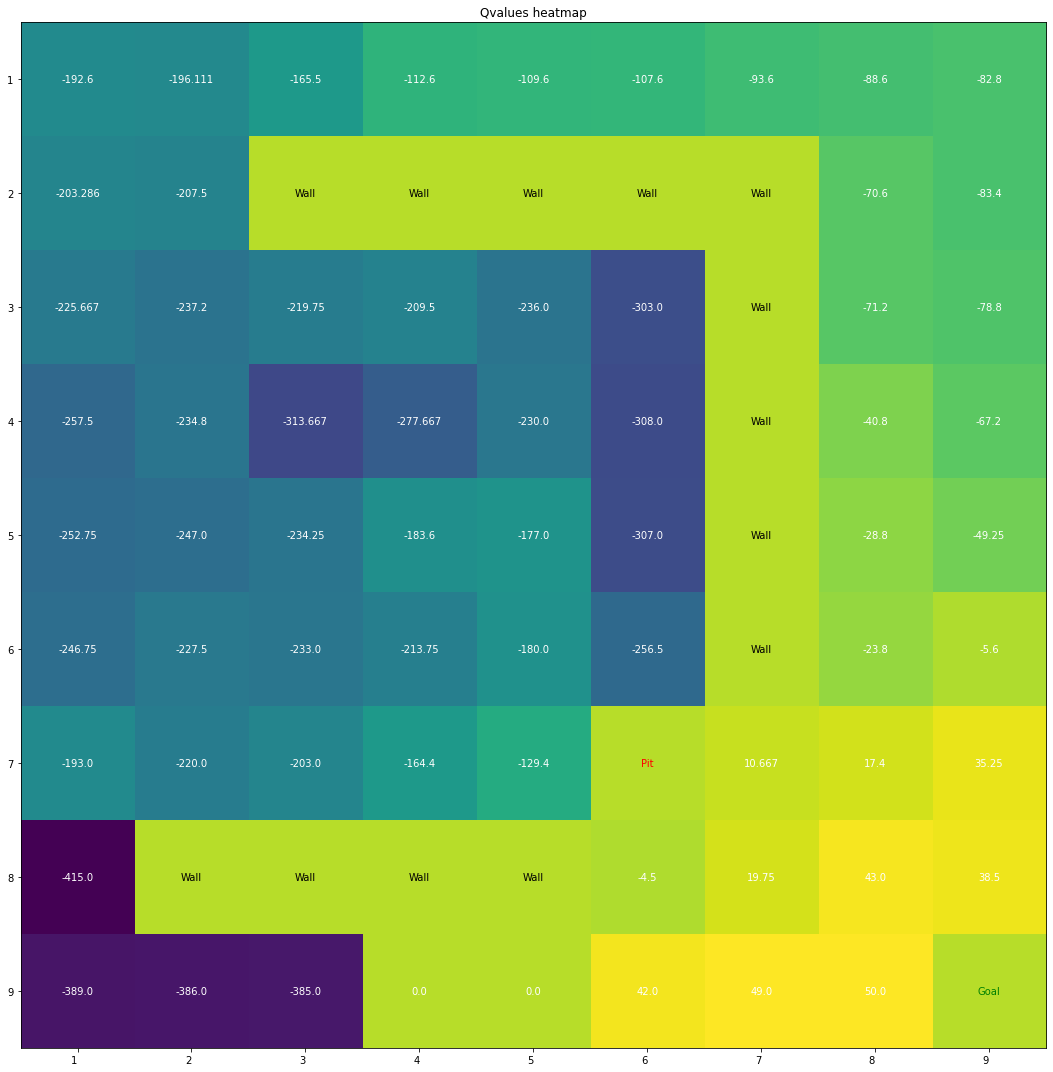

Time: 0.0685112464427948
Heatmap with 100 repetitions


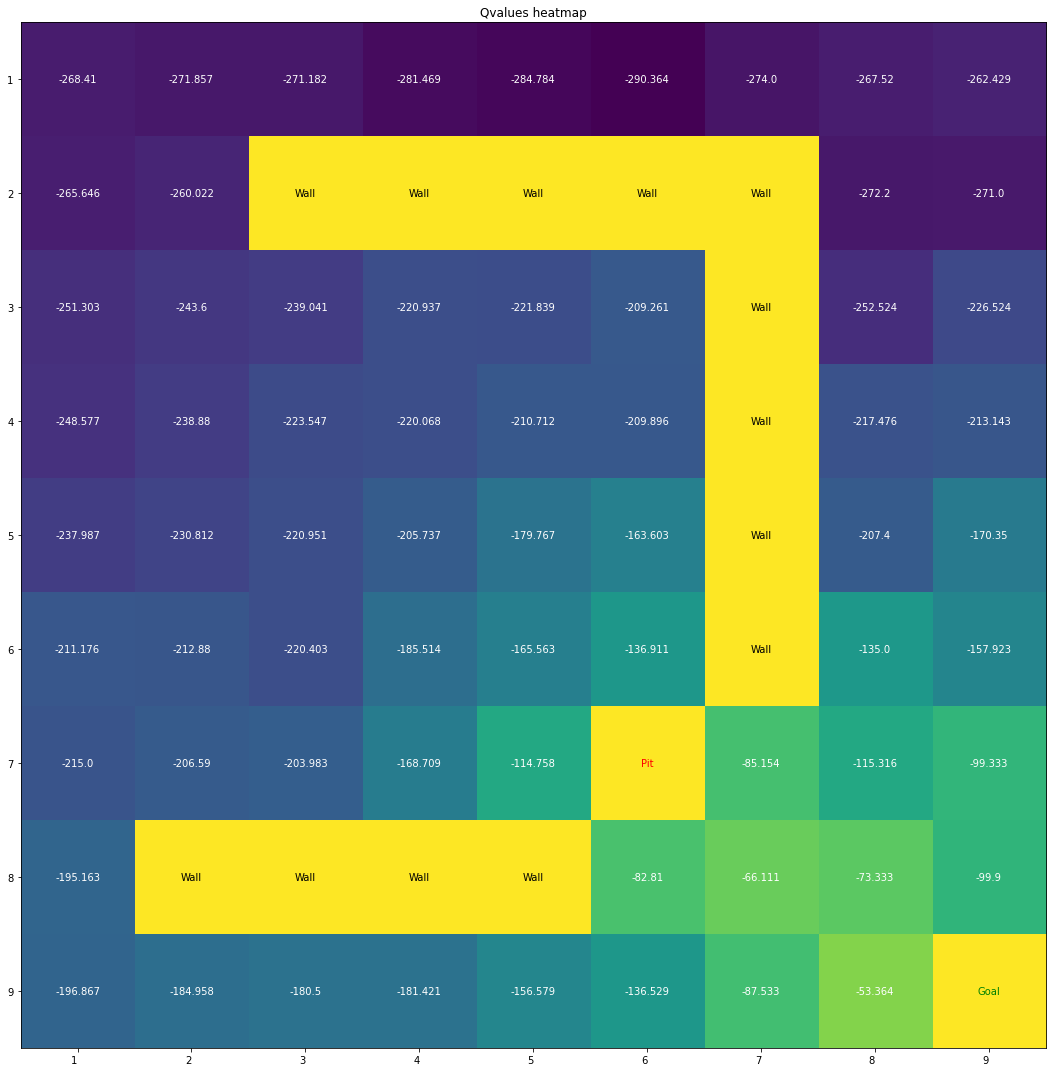

Time: 0.67034077501297
Heatmap with 300 repetitions


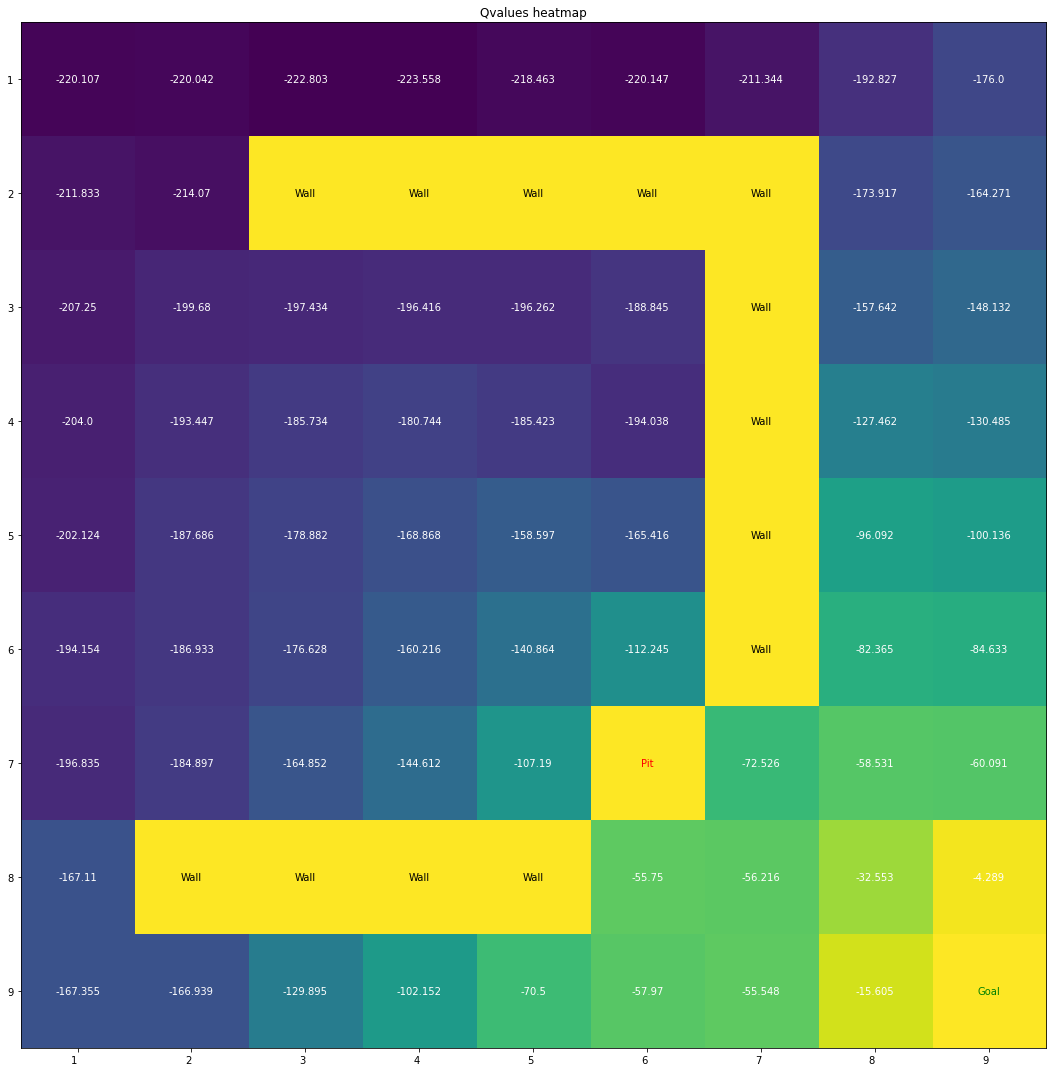

Time: 1.998023196220398


KeyboardInterrupt: ignored

In [ ]:
for repetition in repetitions:
  time_ = []
  for _ in range(1000):
    world = World()
    world.create_map()
    start = time.time()
    MC = MonteCarlo(world,policy, gamma=1)
    MC.simulation(repetitions=repetition)
    MC.update()
    end = time.time()
    time_.append(end-start)
  print("Heatmap with {} repetitions".format(repetition))
  world.plot_map(is_vvalue=True)
  print("Time:", np.mean(time_))

#### Every-visit Results

Heatmap with 10 repetitions


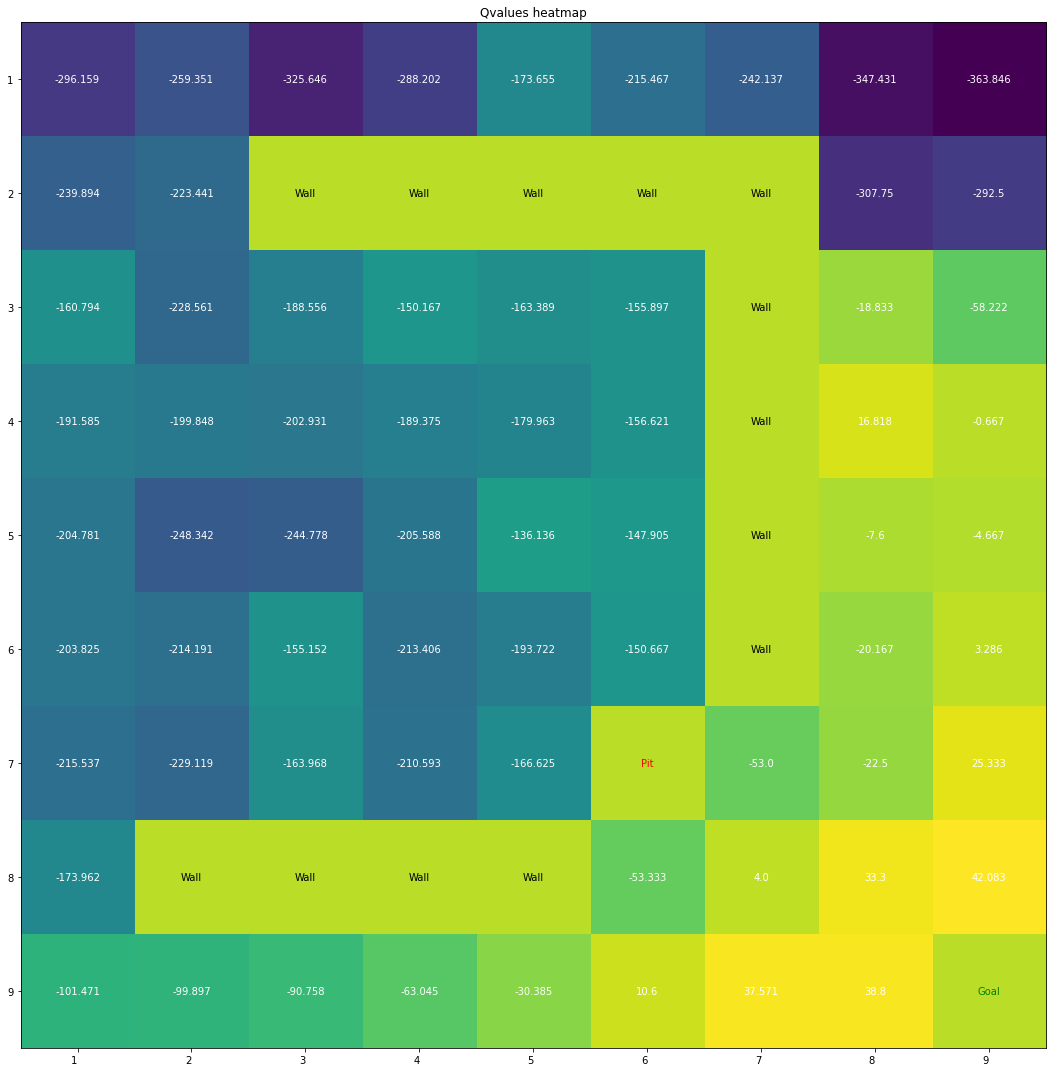

Time: 0.10162745380401611
Heatmap with 100 repetitions


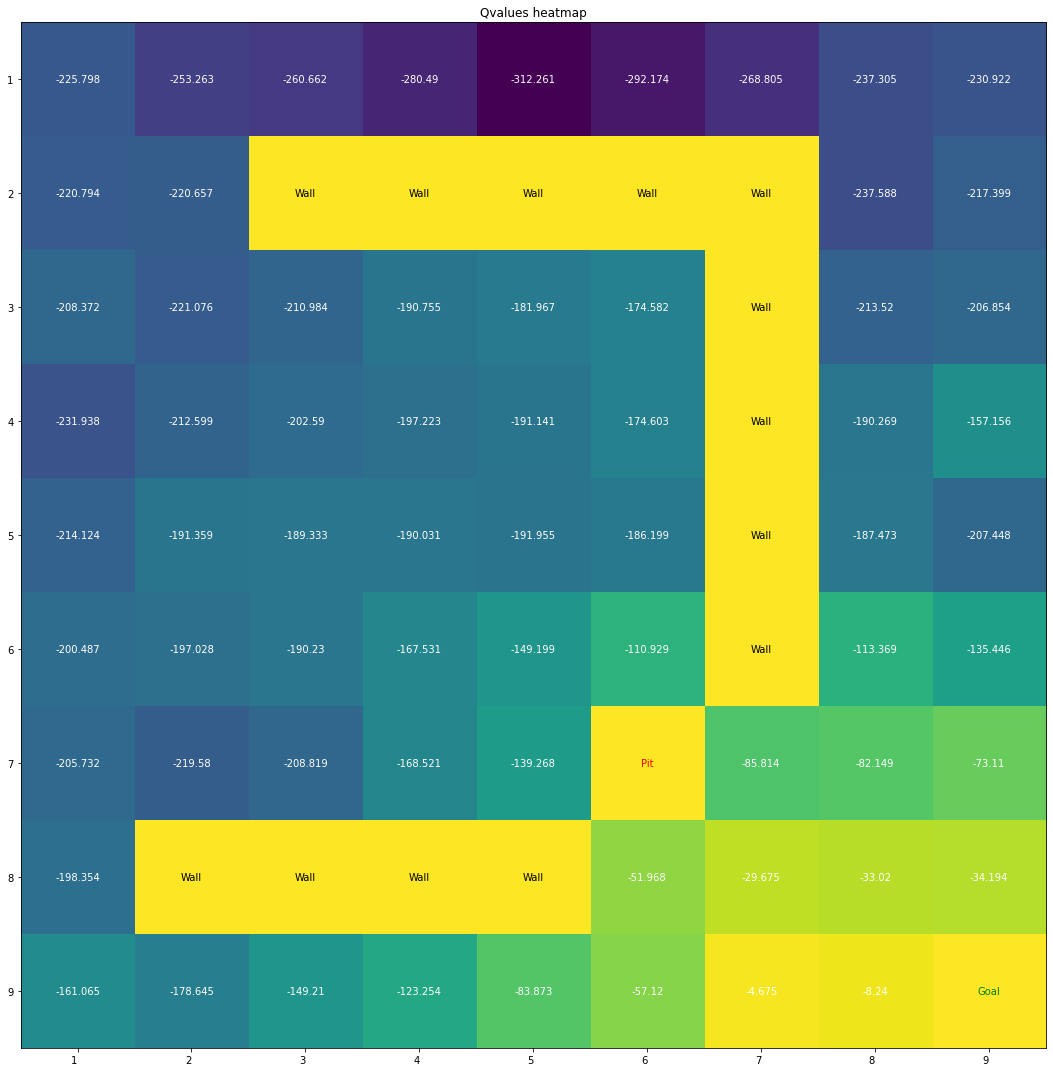

Time: 1.0003142039775847
Heatmap with 300 repetitions


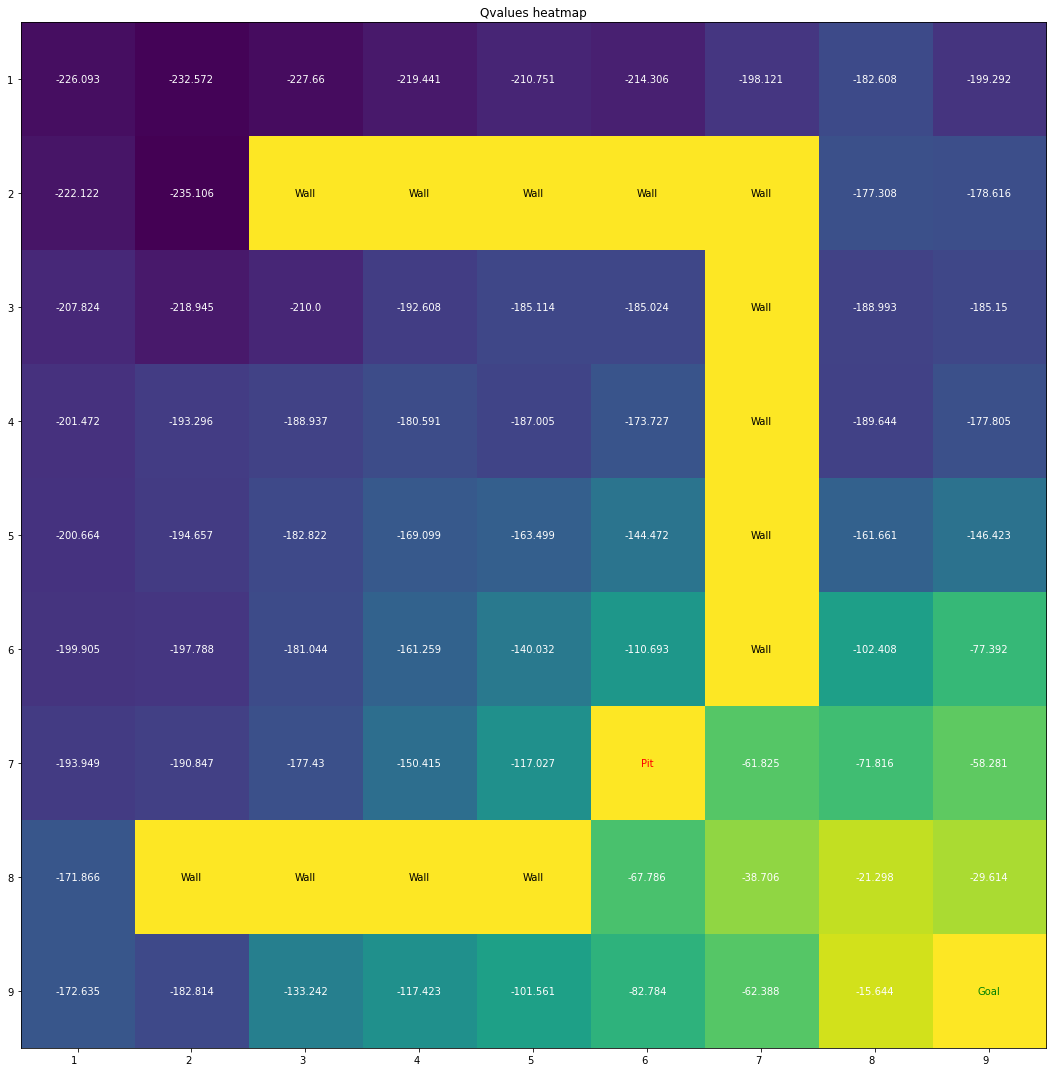

Time: 3.002413500070572


In [ ]:
for repetition in repetitions:
  time_ = []
  for _ in range(1000):
    world = World()
    world.create_map()
    start = time.time()
    MC = MonteCarlo(world,policy, gamma=1)
    MC.simulation(repetitions=repetition,first_visit_on=False)
    MC.update()
    end = time.time()
    time_.append(end-start)
  print("Heatmap with {} repetitions".format(repetition))
  world.plot_map(is_vvalue=True)
  print("Time:", np.mean(time_))

### Learning Agent

In [ ]:
from abc import ABC, abstractmethod

class LearningAgent(ABC):
    def __init__(self, alpha=0.5, epsilon=0.25, discount=1):
        """
        Learning Agent
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        """
        self.get_legal_actions = Actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        state.set_qvalue(action, value)
        self._qvalues[state][action] = value

    def update(self, state, action, reward, next_state, *args, **kwargs):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        pass
    
    def compute(self, world, start_x = 0, start_y = 0, verbose = False):
      """
      This function should
      - run a full game, actions given by agent's e-greedy policy
      - train agent using agent.update(...) whenever it is possible
      - return total reward
      """
      pass


    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """
        # Pick Action
        possible_actions = self.get_legal_actions
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        exploration = np.random.random()
        if exploration<epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

In [ ]:
"""
Fixed parameters
"""
repetitions = 1000
episodes = [10,100,300,500,1000]

### SARSA greedy
Algorithm:
* Initialize Q(s,a)
* Loop:
  - Sample <i>s, a, r, s', a'</i>
  - Compute <i>Q(s,a)=r(s,a)+gamma max Q(s',ai)</i>
  - Update <i>Q(s,a)<-- alpha*Q(s,a)+(1-alpha)Q(s,a)</i>

In [ ]:
class SarsaAgent(LearningAgent):
  # Override
  def update(self, state, action, reward, next_state, next_action, *args, **kwargs):
    # agent parameters
    gamma = self.discount
    learning_rate = self.alpha

    qvalue_target = reward + gamma*self.get_qvalue(next_state, next_action)
    qvalue = learning_rate*qvalue_target+(1-learning_rate)*self.get_qvalue(state,action)

    self.set_qvalue(state, action, qvalue)
  
  # Override
  def compute(self, world, start_x = 0, start_y = 0, verbose = False):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    states_in_episode = []
    # Initialize S
    s = world.get_cell(start_x,start_y)
    # Choose action A from S using greedy policy 
    a = self.get_action(s)
    while not s.is_absorbing():
      states_in_episode.append(s)
      if verbose:
        print(a)
      # Take action A, observe R, S'
      next_s = world.next_cell(a, s)
      # Choose A' from S' using policy derived ...
      next_a = self.get_action(next_s)
      # train (update) agent for state s
      self.update(s, a, next_s.immediate_reward, next_s, next_a)
      # S <-- S'
      s = next_s
      # A <-- A'
      a = next_a
      total_reward += next_s.immediate_reward

    return total_reward, states_in_episode

Results with 10 episodes
followed path: [(0, 0), (1, 0), (2, 0), (1, 0), (1, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (3, 1), (2, 1), (2, 0), (3, 0), (2, 0), (2, 1), (3, 1), (4, 1), (3, 1), (3, 2), (4, 2), (5, 2), (6, 2), (5, 2), (5, 1), (5, 0), (5, 1), (4, 1), (4, 0), (3, 0), (2, 0), (2, 0), (1, 0), (2, 0), (2, 0), (1, 0), (1, 1), (0, 1), (0, 2), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1), (1, 1), (1, 0), (0, 0), (1, 0), (1, 1), (1, 0), (0, 0), (0, 1), (0, 1), (0, 2), (0, 3), (0, 3), (0, 3), (0, 2), (0, 2), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 3), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 5), (0, 4), (0, 4), (0, 5), (0, 5), (0, 5), (0, 6), (0, 6), (0, 5), (0, 5), (0, 5), (0, 6), (0, 6), (0, 6), (0, 5), (0, 6), (0, 7), (0, 6), (0, 5), (0, 5), (0, 5), (0, 5), (0, 6), (0, 6), (0, 6), (0, 7), (0, 7), (0, 6), (0, 6), (0, 7), (1, 7), (0, 7), (0, 8), (0, 8), (0, 8), (1, 8), (1, 7), (1, 8), (1, 8), (1, 8), (1, 7), (1, 7), (0, 7), (1, 7), (2, 7), (2, 8), (1, 8), (0, 8), (0, 8), (0, 8),

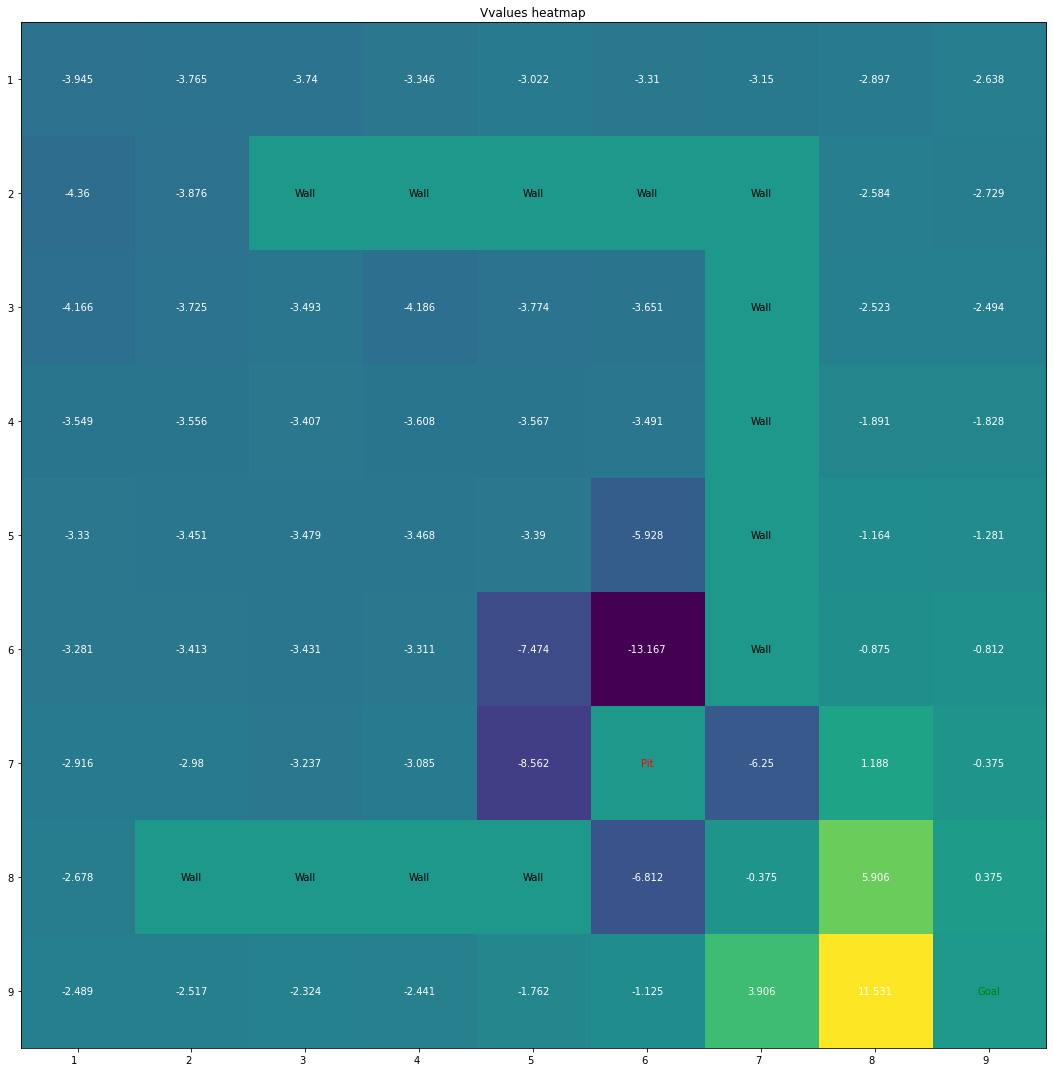

Results with 100 episodes
followed path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (5, 0), (5, 1), (5, 0), (5, 1), (6, 1), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 4), (8, 5), (8, 6), (8, 7)]
Average total reward:  -17.47206
Average execution time:  0.12680802631378174


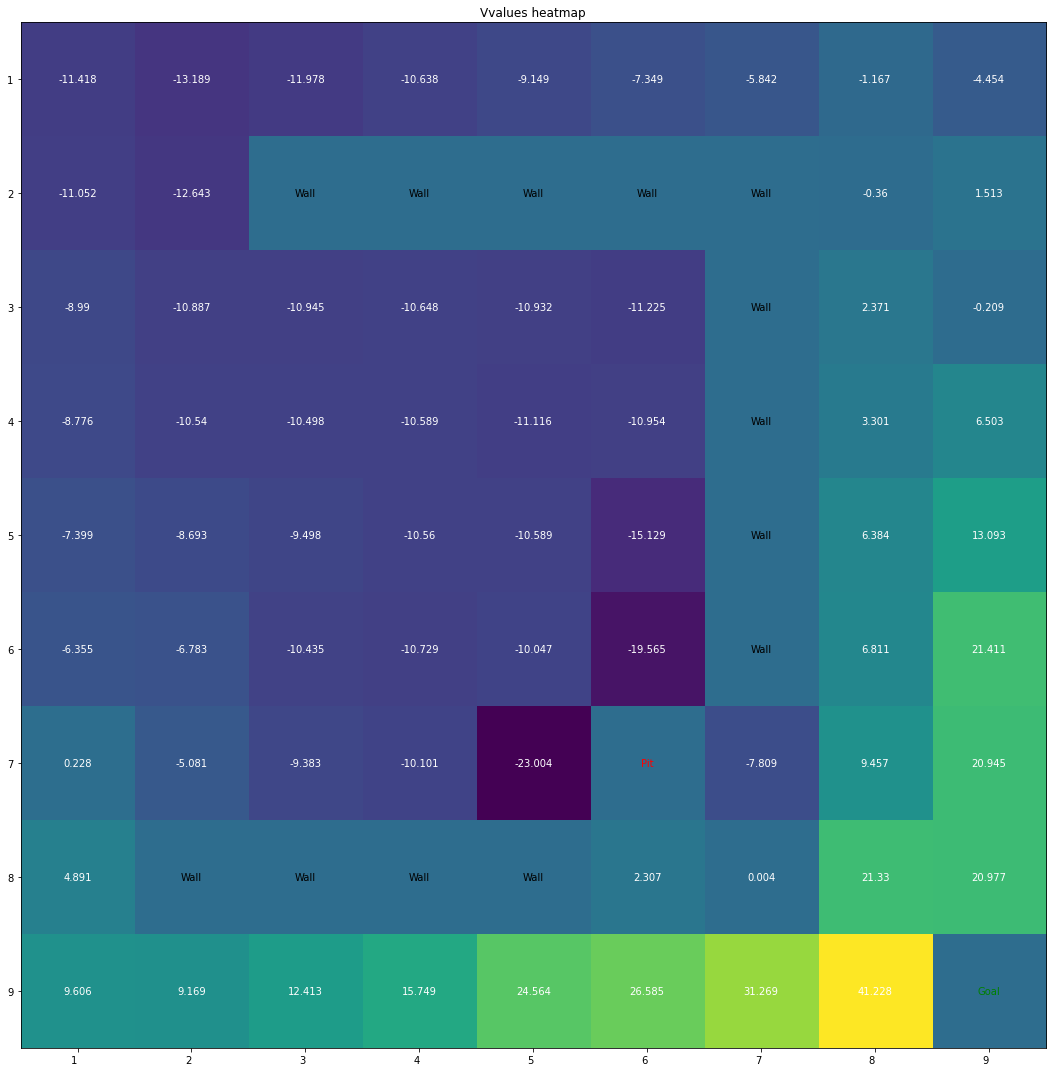

Results with 300 episodes
followed path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 6), (0, 7), (1, 7), (2, 7), (3, 7), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8)]
Average total reward:  9.14699
Average execution time:  0.24732528400421142


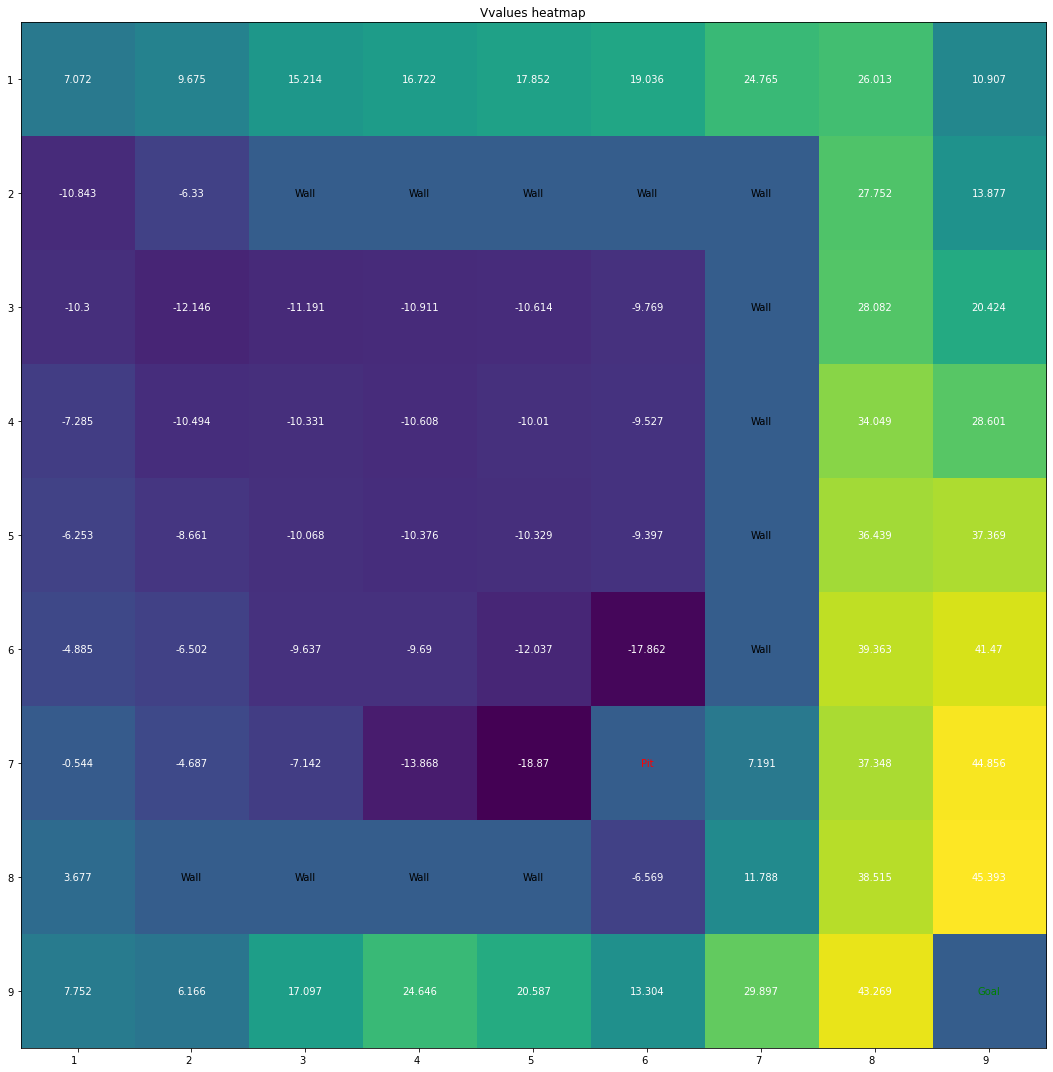

Results with 500 episodes
followed path: [(0, 0), (1, 0), (2, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 3), (8, 4), (8, 4), (8, 5), (8, 6), (8, 5), (8, 6), (8, 7)]
Average total reward:  14.788354
Average execution time:  0.3666525475978851


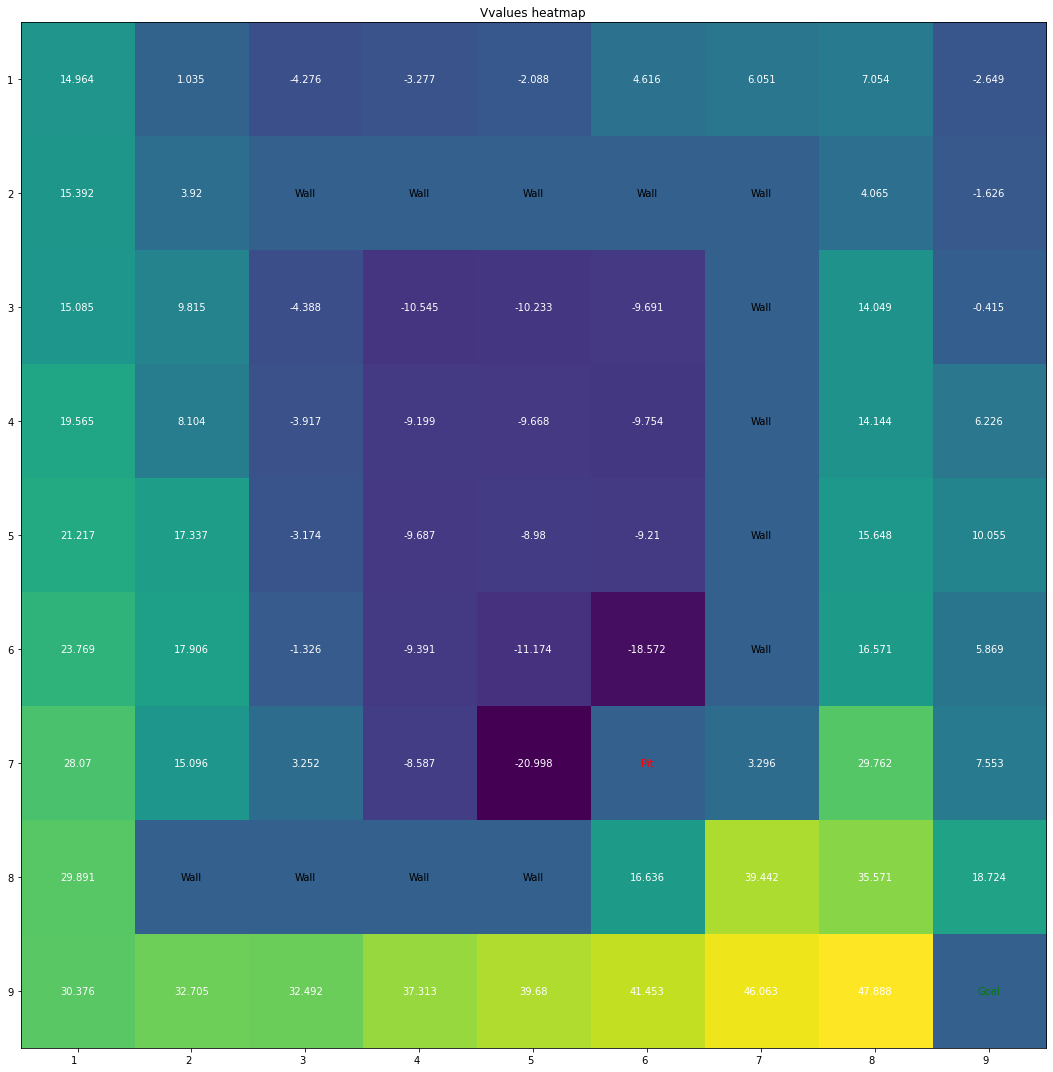

Results with 1000 episodes
followed path: [(0, 0), (0, 1), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 6), (0, 6), (0, 6), (0, 7), (1, 7), (2, 7), (2, 7), (3, 7), (4, 7), (5, 7), (5, 8), (6, 8), (7, 8)]
Average total reward:  19.652621
Average execution time:  0.6587458355426788


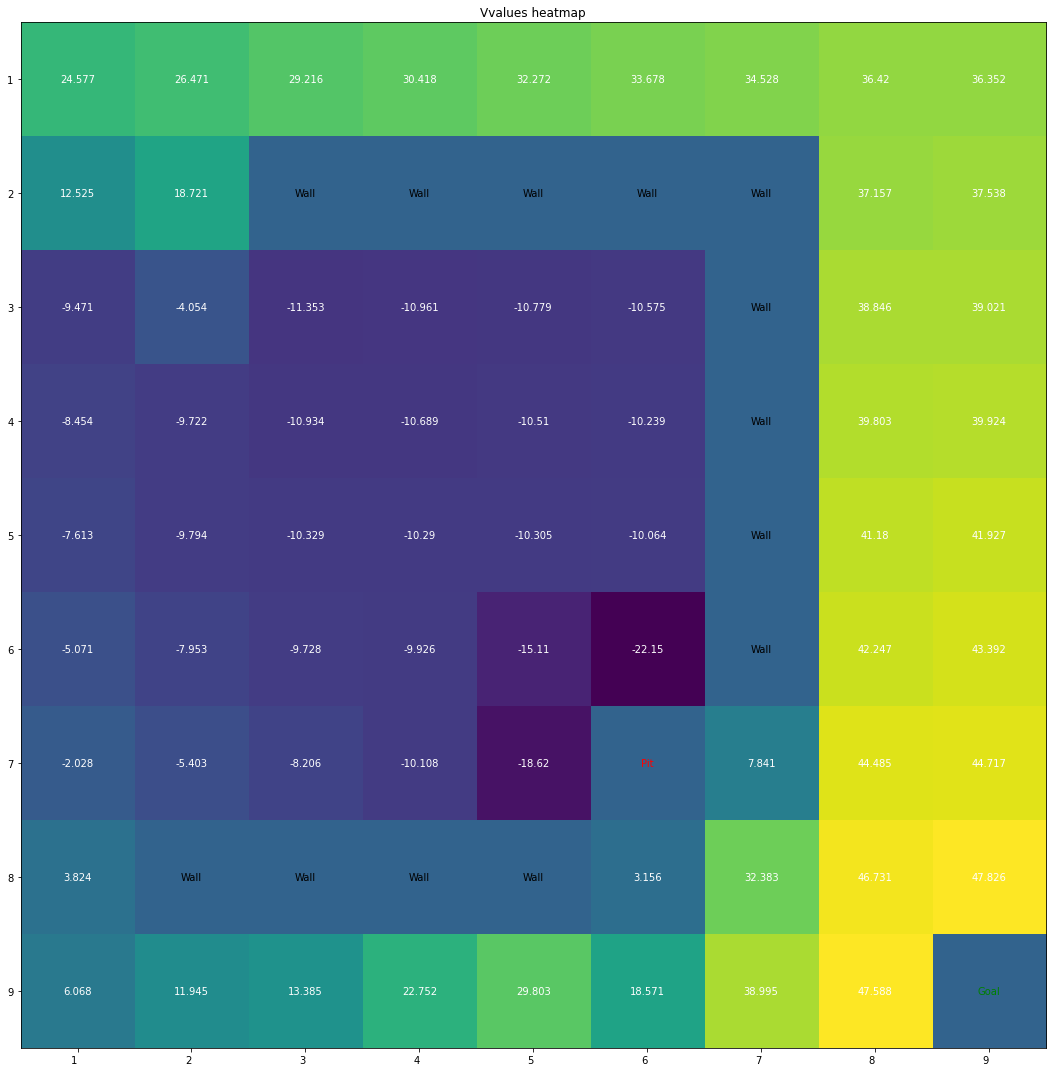

In [ ]:
res = defaultdict(lambda: [])
time_ = defaultdict(lambda: [])
for k,episode in enumerate(episodes):
  for _ in range(repetitions):
    world = World()
    world.create_map()
    sarsa_agent = SarsaAgent()
    tr = []
    start = time.time()
    for i in range(episode):
      ret, sie = sarsa_agent.compute(world)
      tr.append(ret)
    end = time.time()
    res[k].append(np.mean(tr))
    time_[k].append(end-start)
  print('Results with {} episodes'.format(episode))
  print('followed path:', [state.coordinates for state in sie])
  print('Average total reward: ', np.mean(list(res[k])))
  print('Average execution time: ', np.mean(list(time_[k])))
  world.plot_map()

### QLearning Agent
Algorithm:
* Initialize Q(s,a)
* Loop:
  - Sample <i>s, a, r, s'</i>
  - Compute <i>Q(s,a)=r(s,a)+gamma max Q(s',ai)</i>
  - Update <i>Q(s,a)<-- alpha*Q(s,a)+(1-alpha)Q(s,a)</i>

In [ ]:
class QLearningAgent(LearningAgent):
  def update(self, state, action, reward, next_state, *args, **kwargs):
    # agent parameters
    gamma = self.discount
    learning_rate = self.alpha

    qvalue_target = reward+gamma*self.get_value(next_state)
    qvalue = learning_rate*qvalue_target+(1-learning_rate)*self.get_qvalue(state,action)

    self.set_qvalue(state, action, qvalue)

  def get_value(self, state):
    """
    Compute your agent's estimate of V(s) using current q-values
    V(s) = max_over_action Q(state,action) over possible actions.
    Note: please take into account that q-values can be negative.
    """
    possible_actions = self.get_legal_actions

    #If there are no legal actions, return 0.0
    if len(possible_actions) == 0:
        return 0.0
    value = max([self.get_qvalue(state,action) for action in possible_actions])
    return value

  def compute(self, world, start_x = 0, start_y = 0, verbose = False):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    states_in_episode = []
    # Initialize S
    s = world.get_cell(start_x,start_y)

    while not s.is_absorbing():
      # Choose A from S using policy ...
      a = self.get_action(s)

      states_in_episode.append(s)
      if verbose:
        print(a)
      # Take action A, observe R, S'
      next_s = world.next_cell(a, s)
      # train (update) agent for state s
      self.update(s, a, next_s.immediate_reward, next_s)
      # S <-- S'
      s = next_s
      total_reward += next_s.immediate_reward

    return total_reward, states_in_episode

Results with 10 episodes
followed path: [(0, 0), (0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (2, 3), (2, 3), (2, 2), (2, 2), (3, 2), (3, 1), (3, 2), (3, 3), (4, 3), (3, 3), (3, 4), (3, 5), (3, 5), (3, 4), (2, 4), (2, 3), (2, 4), (2, 5), (2, 5), (2, 5), (2, 4), (2, 4), (2, 4), (3, 4), (3, 3), (2, 3), (2, 3), (2, 4), (2, 3), (2, 3), (2, 2), (2, 3), (2, 3), (3, 3), (3, 2), (4, 2), (4, 1), (3, 1), (3, 0), (3, 0), (3, 1), (2, 1), (3, 1), (3, 2), (3, 1), (3, 0), (4, 0), (3, 0), (3, 0), (2, 0), (3, 0), (3, 1), (4, 1), (4, 0), (4, 0), (4, 1), (5, 1), (4, 1), (4, 2), (3, 2), (2, 2), (2, 2), (2, 1), (1, 1), (1, 1), (0, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 5), (0, 5), (0, 6), (0, 5), (0, 4), (0, 3), (0, 3), (0, 2), (0, 2), (0, 3), (0, 4), (0, 4), (0, 4), (0, 4), (0, 5), (0, 6), (0, 6), (0, 6), (0, 5), (0, 5), (0, 5), (0, 5), (0, 6), (0, 7), (0, 7), (1, 7), (2, 7), (2, 7), (1, 7), (1, 8), (2, 8), (2, 8), (1, 8), (1, 8), (0, 8), (0, 8), (0, 8), (0, 7), (0, 8), (1, 8), (1, 7),

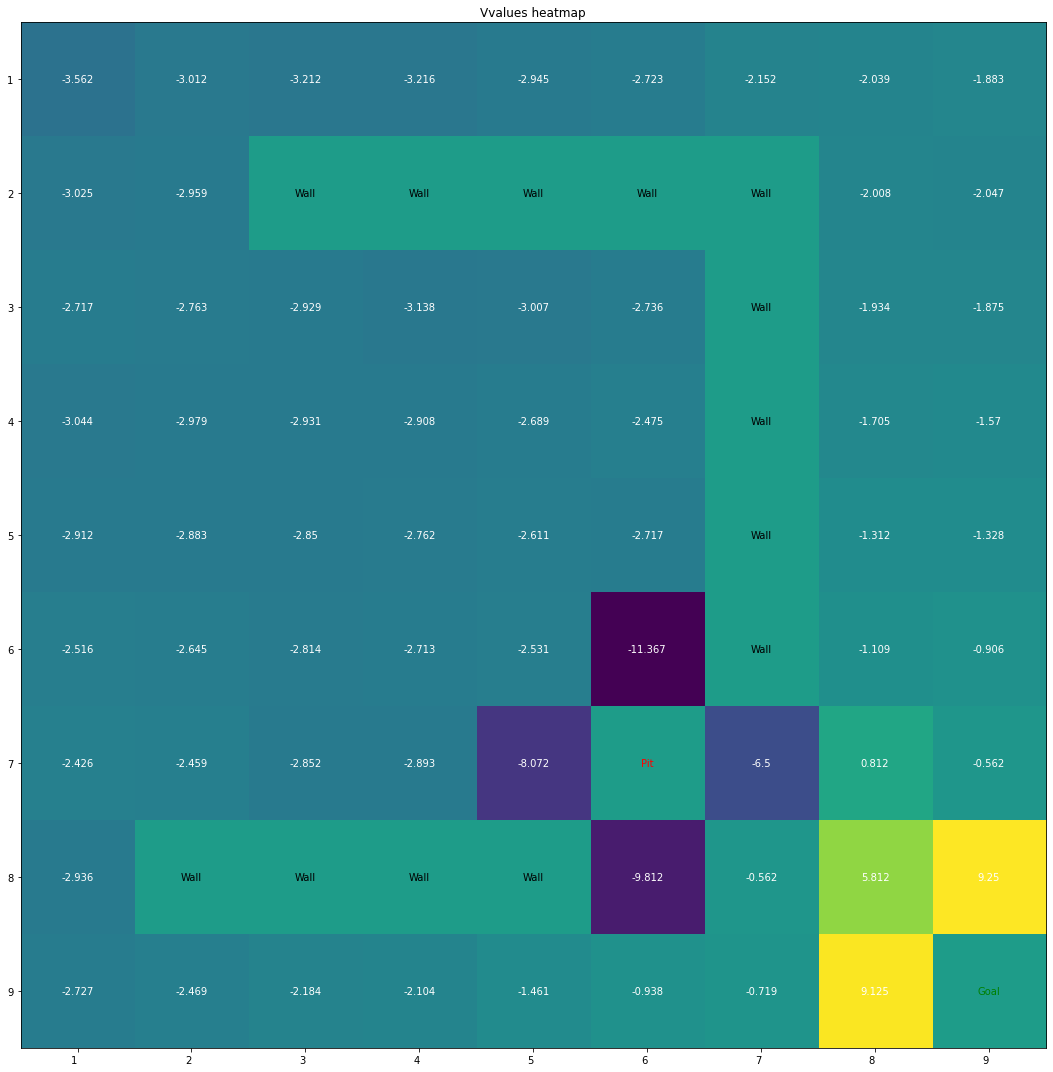

Results with 100 episodes
followed path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 6), (0, 7), (0, 8), (1, 8), (2, 8), (2, 7), (1, 7), (1, 7), (1, 8), (2, 8), (2, 7), (3, 7), (2, 7), (3, 7), (2, 7), (3, 7), (4, 7), (4, 8), (5, 8), (6, 8), (7, 8)]
Average total reward:  -11.578119999999998
Average execution time:  0.13048877239227294


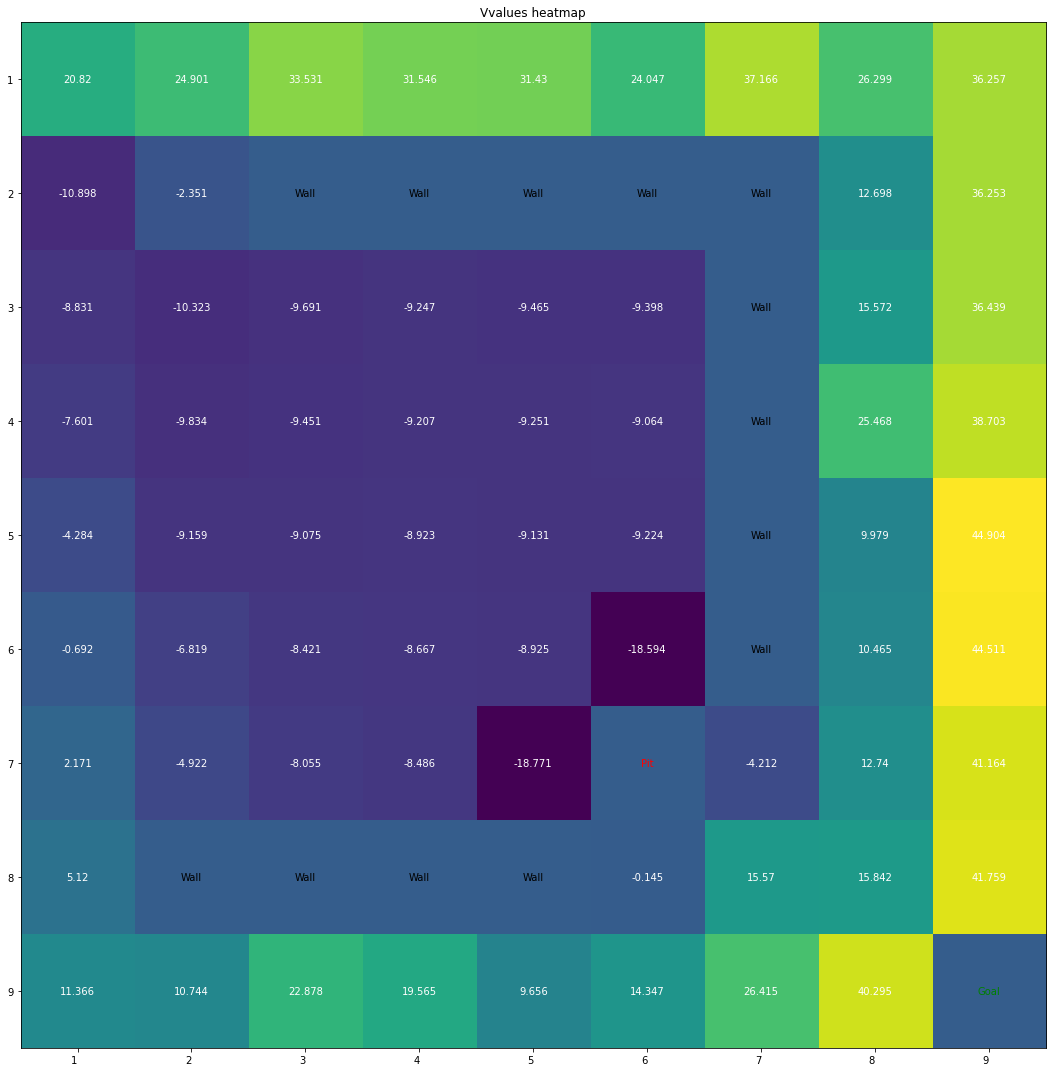

Results with 300 episodes
followed path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (7, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]
Average total reward:  14.991970000000002
Average execution time:  0.24250669884681703


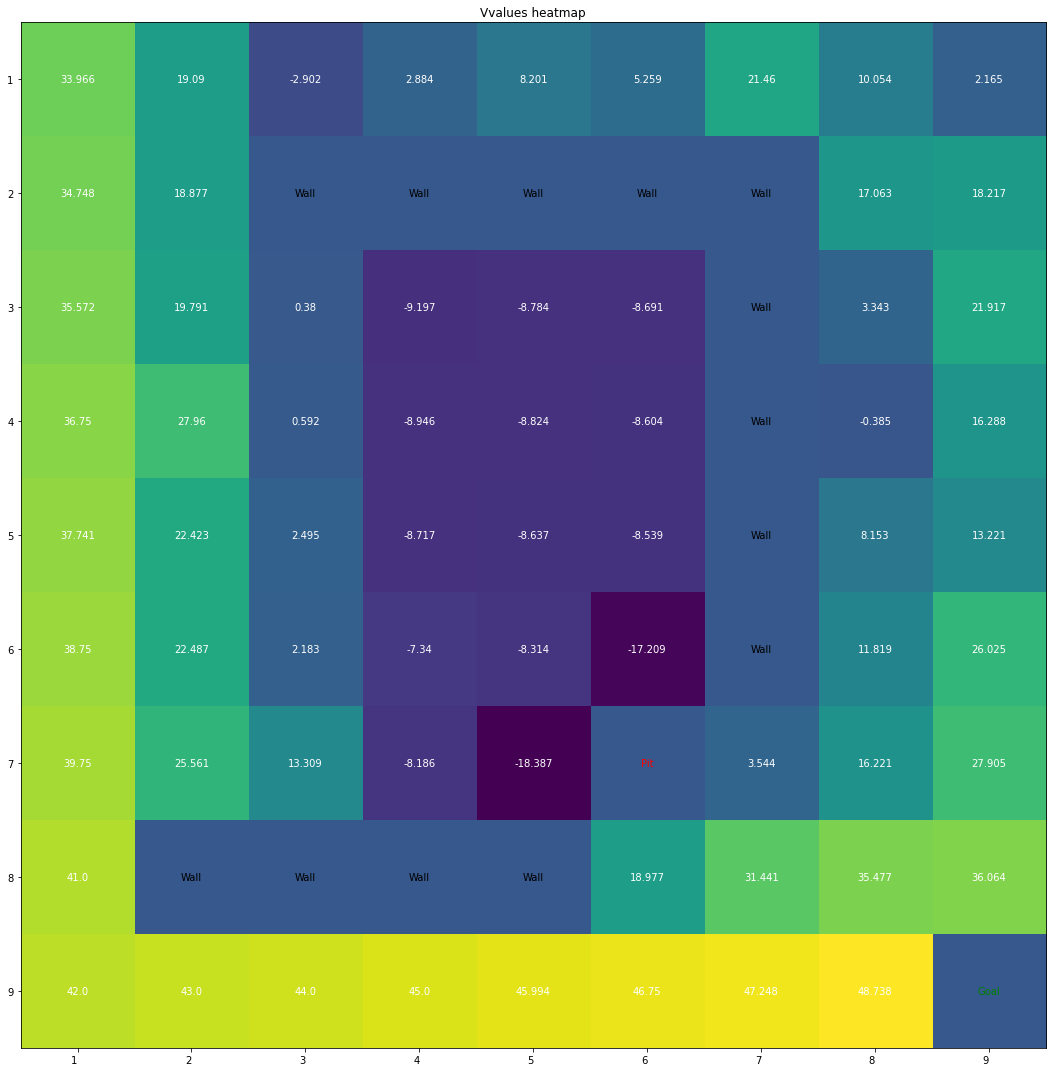

Results with 500 episodes
followed path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 4), (8, 4), (8, 5), (8, 6), (8, 7)]
Average total reward:  20.374796000000003
Average execution time:  0.3547188124656677


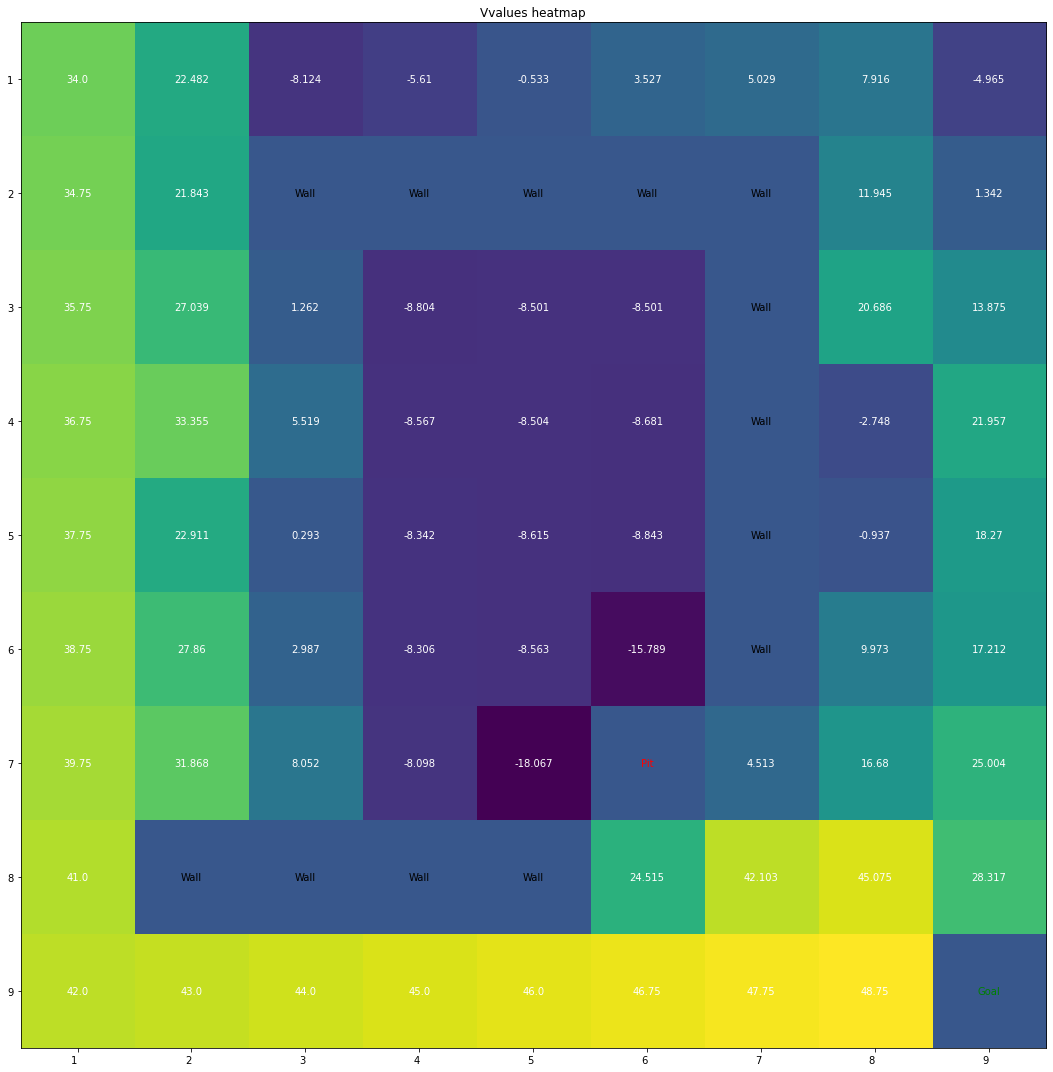

Results with 1000 episodes
followed path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (4, 8), (5, 8), (5, 8), (4, 8), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7)]
Average total reward:  24.601331
Average execution time:  0.624147611618042


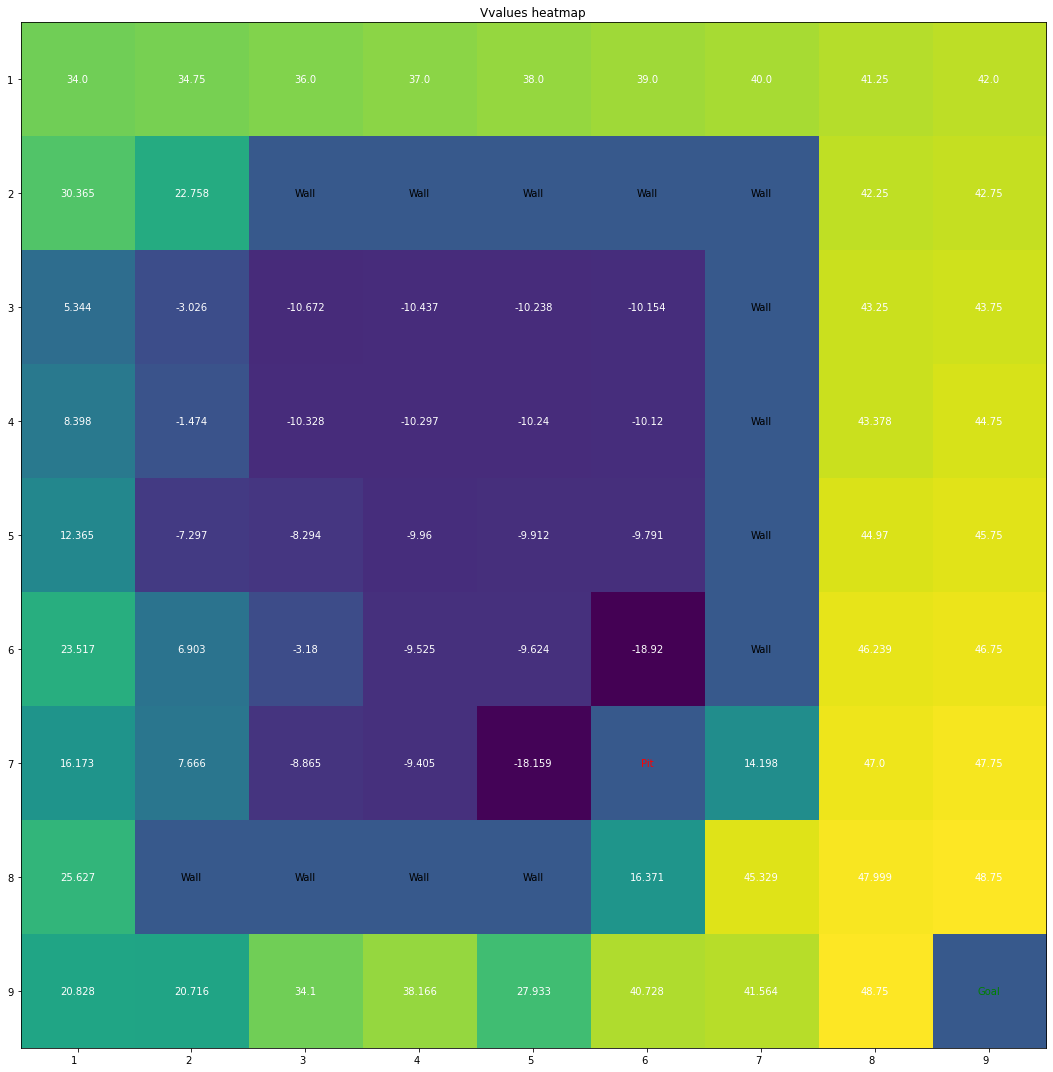

In [ ]:
res = defaultdict(lambda: [])
time_ = defaultdict(lambda: [])
for k,episode in enumerate(episodes):
  for _ in range(repetitions):
    world = World()
    world.create_map()
    qagent = QLearningAgent()
    tr = []
    start = time.time()
    for i in range(episode):
      ret, sie = qagent.compute(world)
      tr.append(ret)
    end = time.time()
    res[k].append(np.mean(tr))
    time_[k].append(end-start)
  print('Results with {} episodes'.format(episode))
  print('followed path:', [state.coordinates for state in sie])
  print('Average total reward: ', np.mean(list(res[k])))
  print('Average execution time: ', np.mean(list(time_[k])))
  world.plot_map()

#### Experiment with high epislon

Results with 500 episodes
followed path: [(0, 0), (1, 0), (1, 1), (1, 0), (2, 0), (2, 1), (2, 0), (2, 0), (3, 0), (2, 0), (2, 0), (2, 1), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (2, 3), (2, 3), (2, 3), (2, 2), (2, 1), (2, 0), (3, 0), (2, 0), (1, 0), (2, 0), (2, 1), (3, 1), (2, 1), (1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (4, 1), (4, 2), (5, 2), (5, 3), (5, 4), (5, 5), (5, 4), (6, 4), (5, 4), (6, 4), (6, 4), (6, 3), (6, 4)]
Average total reward:  -131.785672
Average execution time:  2.1037646346092225


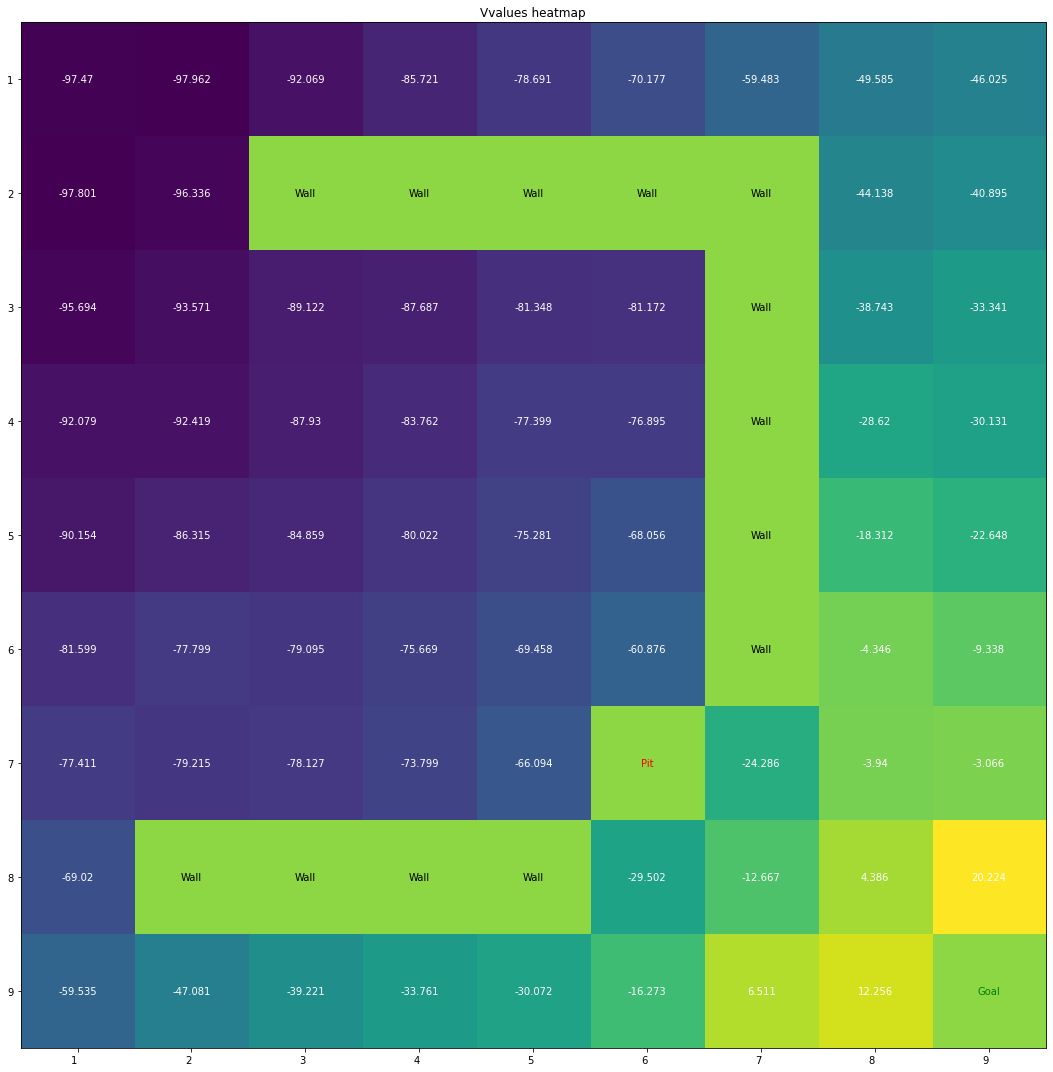

In [ ]:
res = defaultdict(lambda: [])
time_ = defaultdict(lambda: [])
for k,episode in enumerate([500]):
  for _ in range(1000):
    world = World()
    world.create_map()
    sarsa_agent = SarsaAgent(epsilon=0.9)
    tr = []
    start = time.time()
    for i in range(episode):
      ret, sie = sarsa_agent.compute(world)
      tr.append(ret)
    end = time.time()
    res[k].append(np.mean(tr))
    time_[k].append(end-start)
  print('Results with {} episodes'.format(episode))
  print('followed path:', [state.coordinates for state in sie])
  print('Average total reward: ', np.mean(list(res[k])))
  print('Average execution time: ', np.mean(list(time_[k])))
  world.plot_map()

Results with 500 episodes
followed path: [(0, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 0), (1, 0), (2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 1), (1, 1), (2, 1), (3, 1), (2, 1), (3, 1), (3, 2), (3, 3), (3, 4), (2, 4), (3, 4), (3, 3), (2, 3), (3, 3), (3, 2), (3, 1), (3, 0), (3, 0), (4, 0), (4, 0), (5, 0), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (6, 1), (5, 1), (4, 1), (4, 0), (5, 0), (5, 1), (4, 1), (4, 2), (4, 1), (4, 0), (5, 0), (6, 0), (7, 0), (7, 0), (7, 0), (6, 0), (6, 1), (6, 1), (6, 0), (5, 0), (5, 1), (6, 1), (6, 2), (6, 2), (6, 1), (6, 1), (6, 2), (6, 3), (6, 4), (6, 4)]
Average total reward:  -137.842558
Average execution time:  2.909506672143936


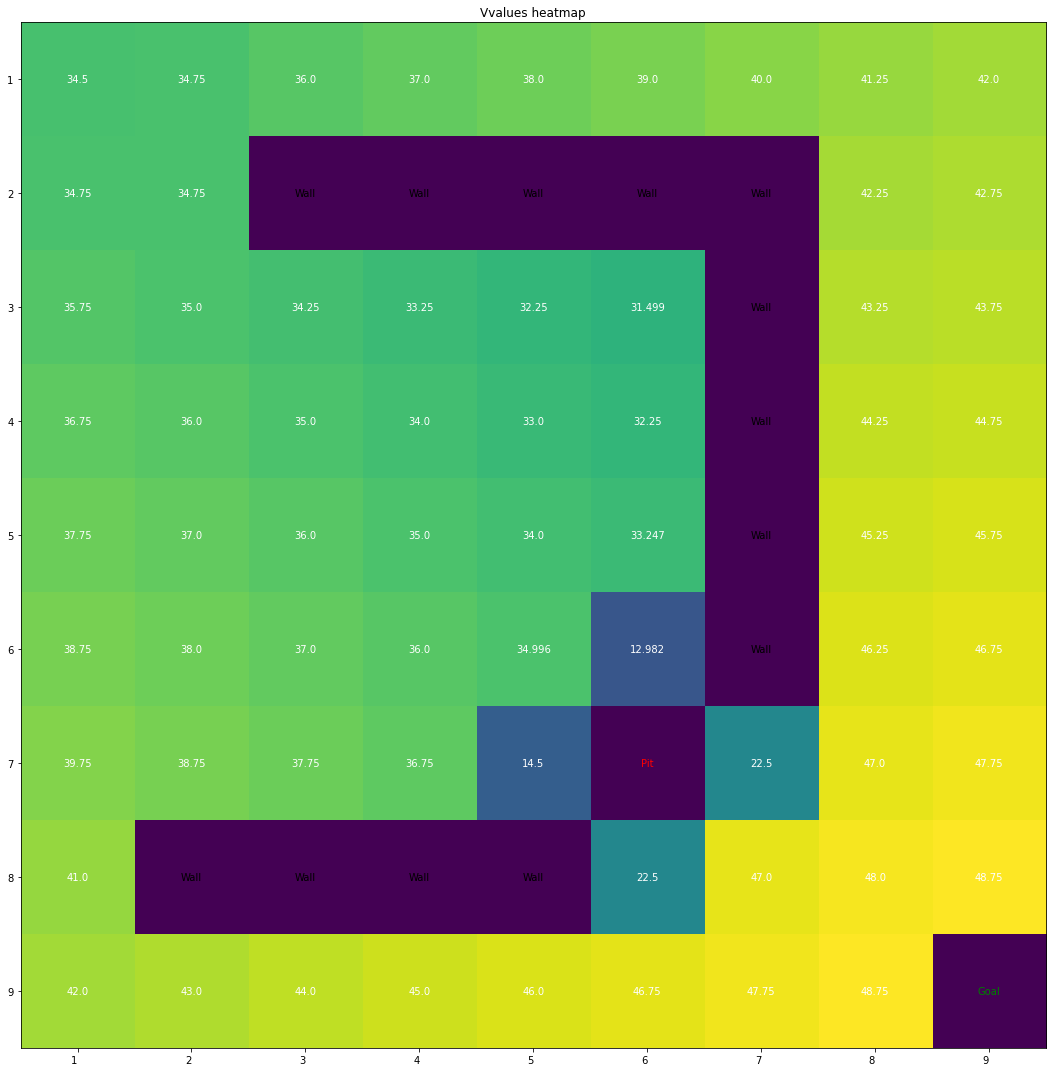

In [ ]:
res = defaultdict(lambda: [])
time_ = defaultdict(lambda: [])
for k,episode in enumerate([500]):
  for _ in range(1000):
    world = World()
    world.create_map()
    q_agent = QLearningAgent(epsilon=0.9)
    tr = []
    start = time.time()
    for i in range(episode):
      ret, sie = q_agent.compute(world)
      tr.append(ret)
    end = time.time()
    res[k].append(np.mean(tr))
    time_[k].append(end-start)
  print('Results with {} episodes'.format(episode))
  print('followed path:', [state.coordinates for state in sie])
  print('Average total reward: ', np.mean(list(res[k])))
  print('Average execution time: ', np.mean(list(time_[k])))
  world.plot_map()